<a href="https://www.kaggle.com/code/rupanshirana/car-s-ex-showroom-price-india-2022?scriptVersionId=122914551" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [571]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/exshowroom-price/cars_engage_2022 (1).csv


In [572]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from pandas.io.formats.style import Styler
import math

import warnings
warnings.filterwarnings('ignore')

tqdm.pandas()

rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

import xgboost as xgb
from xgboost.callback import EarlyStopping
from sklearn import model_selection
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_log_error

In [573]:
def magnify(is_test: bool = False):
        base_color = '#FF5C19'
        if is_test:
            highlight_target_row = []
        else:
            highlight_target_row = [dict(selector='tr:last-child',
                                         props=[('background-color', f'{base_color}'+'20')])]
            
        return [dict(selector="th",
                     props=[("font-size", "11pt"),
                            ('background-color', f'{base_color}'),
                            ('color', 'white'),
                            ('font-weight', 'bold'),
                            ('border-bottom', '0.1px solid white'),
                            ('border-left', '0.1px solid white'),
                            ('text-align', 'right')]),

                dict(selector='th.blank.level0', 
                    props=[('font-weight', 'bold'),
                           ('border-left', '1.7px solid white'),
                           ('background-color', 'white')]),

                dict(selector="td",
                     props=[('padding', "0.5em 1em"),
                            ('text-align', 'right')]),

                dict(selector="th:hover",
                     props=[("font-size", "14pt")]),

                dict(selector="tr:hover td:hover",
                     props=[('max-width', '250px'),
                            ('font-size', '14pt'),
                            ('color', f'{base_color}'),
                            ('font-weight', 'bold'),
                            ('background-color', 'white'),
                            ('border', f'1px dashed {base_color}')]),
                
                 dict(selector="caption",
                      props=[(('caption-side', 'bottom'))])] + highlight_target_row

def stylize_min_max_count(pivot_table):
    """Waps the min_max_count pivot_table into the Styler.

        Args:
            df: |min_train| max_train |min_test |max_test |top10_counts_train |top_10_counts_train|

        Returns:
            s: the dataframe wrapped into Styler.
    """
    s = pivot_table
    # A formatting dictionary for controlling each column precision (.000 <-). 
    di_frmt = {(i if i.startswith('m') else i):
              ('{:.3f}' if i.startswith('m') else '{:}') for i in s.columns}

    s = s.style.set_table_styles(magnify(True))\
        .format(di_frmt)\
        .set_caption(f"The train and test datasets min, max, top10 values side by side (hover to magnify).")
    return s
  
    
def stylize_describe(df: pd.DataFrame, dataset_name: str = 'train', is_test: bool = False) -> Styler:
    """Applies .descibe() method to the df and wraps it into the Styler.
    
        Args:
            df: any dataframe (train/test/origin)
            dataset_name: default 'train'
            is_test: the bool parameter passed into magnify() function
                     in order to control the highlighting of the last row.
                     
        Returns:
            s: the dataframe wrapped into Styler.
    """
    s = df.describe().T
    # A formatting dictionary for controlling each column precision (.000 <-). 
    di_frmt = {(i if i == 'count' else i):
              ('{:.0f}' if i == 'count' else '{:.3f}') for i in s.columns}
    
    s = s.style.set_table_styles(magnify(is_test))\
        .format(di_frmt)\
        .set_caption(f"The {dataset_name} dataset descriptive statistics (hover to magnify).")
    return s

def stylize_simple(df: pd.DataFrame, caption: str) -> Styler:
    """Waps the min_max_count pivot_table into the Styler.

        Args:
            df: any dataframe (train/test/origin)

        Returns:
            s: the dataframe wrapped into Styler.
    """
    s = df
    s = s.style.set_table_styles(magnify(True)).set_caption(f"{caption}")
    return s

display(stylize_simple(df.head(4), 'The train dataset 3 top rows (hover to magnify).'))
display(stylize_describe(df))
stylize_describe(df, 'df', is_test=True)

,Cylinders,Doors,Seating_Capacity,Number_of_Airbags,Make,Model,Variant,Price,Displacement,Drivetrain,Emission_Norm,Keyless_Entry,Power,Torque,Odometer,Speedometer,Tachometer,Tripmeter,Fuel_Type,ARAI_Certified_Mileage,Front_Suspension,Rear_Suspension,Ground_Clearance,Boot_Space,Audiosystem,Third_Row_AC_Vents,Ventilation_System,Auto-Dimming_Rear-View_Mirror,Hill_Assist,Gear_Indicator,ABS_(Anti-lock_Braking_System),EBD_(Electronic_Brake-force_Distribution),Gear_Shift_Reminder,Adjustable_Steering_Column,Parking_Assistance,Key_Off_Reminder,USB_Compatibility,EBA_(Electronic_Brake_Assist),Seat_Height_Adjustment,Navigation_System,Second_Row_AC_Vents,Rear_Center_Armrest,ESP_(Electronic_Stability_Program),Cooled_Glove_Box,Turbocharger,Rain_Sensing_Wipers,Automatic_Headlamps,ASR_/_Traction_Control,Cruise_Control
0,2.000000,5.000000,4.000000,2.000000,Tata,Nano Genx,Xt,292667.000000,624.000000,RWD (Rear Wheel Drive),BS IV,Remote,38.000000,51.000000,Digital,Analog,Not on offer,Yes,Petrol,23.600000,"Independent, Lower Wishbone, McPherson Strut with gas filled dampers and anti-roll bar","Independent, Semi Trailing arm with coil spring & gas filled shock absorbers",180.000000,110.000000,CD Player with USB & Aux-in,Not Applicable,Manual Air conditioning with cooling and heating,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,Manual Adjustment,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined
1,2.000000,5.000000,4.000000,2.000000,Tata,Nano Genx,Xe,236447.000000,624.000000,RWD (Rear Wheel Drive),BS IV,not_defined,38.000000,51.000000,Digital,Analog,Not on offer,Yes,Petrol,23.600000,"Independent, Lower Wishbone, McPherson Strut with gas filled dampers and anti-roll bar","Independent, Semi Trailing arm with coil spring & gas filled shock absorbers",180.000000,110.000000,Not on offer,Not Applicable,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,Manual Adjustment,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined
2,2.000000,4.000000,4.000000,2.000000,Tata,Nano Genx,Emax Xm,296661.000000,624.000000,RWD (Rear Wheel Drive),BS IV,not_defined,38.000000,51.000000,Digital,Analog,Not on offer,Yes,CNG,18.667599,"Independent, Lower Wishbone, McPherson Strut with gas filled dampers and anti-roll bar","Independent, Semi Trailing arm with coil spring & gas filled shock absorbers",180.000000,110.000000,Not on offer,Not Applicable,Air Conditioning with cooling only,Yes,Yes,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,Manual Adjustment,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined
3,2.000000,5.000000,4.000000,2.000000,Tata,Nano Genx,Xta,334768.000000,624.000000,RWD (Rear Wheel Drive),BS IV,Remote,38.000000,51.000000,Digital,Analog,Not on offer,Yes,Petrol,21.900000,"Independent, Lower Wishbone, McPherson Strut with gas filled dampers and anti-roll bar","Independent, Semi Trailing arm with coil spring & gas filled shock absorbers",180.000000,94.000000,CD Player with USB & Aux-in,Not Applicable,Manual Air conditioning with cooling and heating,not_defined,not_defined,Yes,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,Manual Adjustment,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined


,count,mean,std,min,25%,50%,75%,max
Cylinders,1276,4.361,1.620,2.000,4.000,4.000,4.000,16.000
Doors,1276,4.552,0.747,2.000,4.000,5.000,5.000,5.000
Seating_Capacity,1276,5.269,1.143,2.000,5.000,5.000,5.000,16.000
Number_of_Airbags,1276,3.598,2.448,1.000,2.000,2.000,6.000,14.000
Price,1276,4596537.887,12147346.945,236447.000,743876.000,1060064.500,2979827.750,212155397.000
Displacement,1276,1858.805,1058.137,72.000,1198.000,1497.000,1998.000,7993.000
Power,1276,156.538,136.598,12.000,83.000,110.000,173.000,1600.000
Torque,1276,266.523,185.339,8.300,133.000,209.000,350.000,1712.000
ARAI_Certified_Mileage,1276,18.668,8.242,3.400,16.000,18.668,21.040,142.000
Ground_Clearance,1276,179.609,29.117,100.000,165.000,179.609,188.000,498.000


,count,mean,std,min,25%,50%,75%,max
Cylinders,1276,4.361,1.620,2.000,4.000,4.000,4.000,16.000
Doors,1276,4.552,0.747,2.000,4.000,5.000,5.000,5.000
Seating_Capacity,1276,5.269,1.143,2.000,5.000,5.000,5.000,16.000
Number_of_Airbags,1276,3.598,2.448,1.000,2.000,2.000,6.000,14.000
Price,1276,4596537.887,12147346.945,236447.000,743876.000,1060064.500,2979827.750,212155397.000
Displacement,1276,1858.805,1058.137,72.000,1198.000,1497.000,1998.000,7993.000
Power,1276,156.538,136.598,12.000,83.000,110.000,173.000,1600.000
Torque,1276,266.523,185.339,8.300,133.000,209.000,350.000,1712.000
ARAI_Certified_Mileage,1276,18.668,8.242,3.400,16.000,18.668,21.040,142.000
Ground_Clearance,1276,179.609,29.117,100.000,165.000,179.609,188.000,498.000


#### Importing required Libraries

In [574]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
#from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor

In [575]:
pd.set_option("display.max_rows",300)
pd.set_option("display.max_columns",500)

#### Loading the Data Set

In [576]:
df=pd.read_csv("/kaggle/input/exshowroom-price/cars_engage_2022 (1).csv")
df

,Unnamed: 0,Make,Model,Variant,Ex-Showroom_Price,Displacement,Cylinders,Valves_Per_Cylinder,Drivetrain,Cylinder_Configuration,Emission_Norm,Engine_Location,Fuel_System,Fuel_Tank_Capacity,Fuel_Type,Height,Length,Width,Body_Type,Doors,City_Mileage,Highway_Mileage,ARAI_Certified_Mileage,ARAI_Certified_Mileage_for_CNG,Kerb_Weight,Gears,Ground_Clearance,Front_Brakes,Rear_Brakes,Front_Suspension,Rear_Suspension,Front_Track,Rear_Track,Front_Tyre_&_Rim,Rear_Tyre_&_Rim,Power_Steering,Power_Windows,Power_Seats,Keyless_Entry,Power,Torque,Odometer,Speedometer,Tachometer,Tripmeter,Seating_Capacity,Seats_Material,Type,Wheelbase,Wheels_Size,Start_/_Stop_Button,12v_Power_Outlet,Audiosystem,Aux-in_Compatibility,Average_Fuel_Consumption,Basic_Warranty,Bluetooth,Boot-lid_Opener,Boot_Space,CD_/_MP3_/_DVD_Player,Central_Locking,Child_Safety_Locks,Clock,Cup_Holders,Distance_to_Empty,Door_Pockets,Engine_Malfunction_Light,Extended_Warranty,FM_Radio,Fuel-lid_Opener,Fuel_Gauge,Handbrake,Instrument_Console,Low_Fuel_Warning,Minimum_Turning_Radius,Multifunction_Display,Sun_Visor,Third_Row_AC_Vents,Ventilation_System,Auto-Dimming_Rear-View_Mirror,Hill_Assist,Gear_Indicator,3_Point_Seat-Belt_in_Middle_Rear_Seat,Ambient_Lightning,Cargo/Boot_Lights,Drive_Modes,Engine_Immobilizer,High_Speed_Alert_System,Lane_Watch_Camera/_Side_Mirror_Camera,Passenger_Side_Seat-Belt_Reminder,Seat_Back_Pockets,Voice_Recognition,Walk_Away_Auto_Car_Lock,ABS_(Anti-lock_Braking_System),Headlight_Reminder,Adjustable_Headrests,Gross_Vehicle_Weight,Airbags,Door_Ajar_Warning,EBD_(Electronic_Brake-force_Distribution),Fasten_Seat_Belt_Warning,Gear_Shift_Reminder,Number_of_Airbags,Compression_Ratio,Adjustable_Steering_Column,Other_Specs,Other_specs,Parking_Assistance,Key_Off_Reminder,USB_Compatibility,Android_Auto,Apple_CarPlay,Cigarette_Lighter,Infotainment_Screen,Multifunction_Steering_Wheel,Average_Speed,EBA_(Electronic_Brake_Assist),Seat_Height_Adjustment,Navigation_System,Second_Row_AC_Vents,Tyre_Pressure_Monitoring_System,Rear_Center_Armrest,iPod_Compatibility,ESP_(Electronic_Stability_Program),Cooled_Glove_Box,Recommended_Tyre_Pressure,Heated_Seats,Turbocharger,ISOFIX_(Child-Seat_Mount),Rain_Sensing_Wipers,Paddle_Shifters,Leather_Wrapped_Steering,Automatic_Headlamps,Engine_Type,ASR_/_Traction_Control,Cruise_Control,USB_Ports,Heads-Up_Display,Welcome_Lights,Battery,Electric_Range
0,0,Tata,Nano Genx,Xt,"Rs. 2,92,667",624 cc,2.0,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",Injection,24 litres,Petrol,1652 mm,3164 mm,1750 mm,Hatchback,5.0,?23.6 km/litre,NaN,23.6 km/litre,NaN,660 kg,4,180 mm,Drum,Drum,"Independent, Lower Wishbone, McPherson Strut w...","Independent, Semi Trailing arm with coil sprin...",1325 mm,1315 mm,135/70R12,155/65R12,Electric Power,Only Front Windows,NaN,Remote,38PS@5500rpm,51Nm@4000rpm,Digital,Analog,Not on offer,Yes,4.0,Fabric,Manual,2230 mm,4 B X 12,Yes,Yes,CD Player with USB & Aux-in,Yes,Yes,2 years /75000 Kms (years/distance whichever c...,Yes,Internal,110 litres,Yes,Yes,Yes,Digital,Front,Yes,Front,Yes,2 years /150000 Kms (years/distance whichever ...,Yes,Internal,Digital,Manual,Analog + Digital,Yes,4 meter,Yes,Driver & Front Passenger,Not Applicable,Manual Air conditioning with cooling and heating,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Tata,Nano Genx,Xe,"Rs. 2,36,447",624 cc,2.0,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",Injection,24 litres,Petrol,1652 mm,3164 mm,1750 mm,Hatchback,5.0,?23.6 km/litre,NaN,23.6 km/litre,NaN,725 kg,4,180 mm,Drum,Drum,"Independent, Lower Wishbone, McPherson Strut w...","Independent, Semi Trailing arm with coil sprin...",1325 mm,1315 mm,135/70R12,155/65R12,NaN,NaN,NaN,NaN,38PS@5500rpm,51Nm@4000rpm,Digital,Analog,Not on offer,Yes,4.0,Fabric,Manual,2230 mm,4 B X 12,NaN,Yes,Not on offer,NaN,Yes,2

#### Checking shape

In [577]:
df.shape

(1276, 141)

#### Preview of Data

In [578]:
df.head()

,Unnamed: 0,Make,Model,Variant,Ex-Showroom_Price,Displacement,Cylinders,Valves_Per_Cylinder,Drivetrain,Cylinder_Configuration,Emission_Norm,Engine_Location,Fuel_System,Fuel_Tank_Capacity,Fuel_Type,Height,Length,Width,Body_Type,Doors,City_Mileage,Highway_Mileage,ARAI_Certified_Mileage,ARAI_Certified_Mileage_for_CNG,Kerb_Weight,Gears,Ground_Clearance,Front_Brakes,Rear_Brakes,Front_Suspension,Rear_Suspension,Front_Track,Rear_Track,Front_Tyre_&_Rim,Rear_Tyre_&_Rim,Power_Steering,Power_Windows,Power_Seats,Keyless_Entry,Power,Torque,Odometer,Speedometer,Tachometer,Tripmeter,Seating_Capacity,Seats_Material,Type,Wheelbase,Wheels_Size,Start_/_Stop_Button,12v_Power_Outlet,Audiosystem,Aux-in_Compatibility,Average_Fuel_Consumption,Basic_Warranty,Bluetooth,Boot-lid_Opener,Boot_Space,CD_/_MP3_/_DVD_Player,Central_Locking,Child_Safety_Locks,Clock,Cup_Holders,Distance_to_Empty,Door_Pockets,Engine_Malfunction_Light,Extended_Warranty,FM_Radio,Fuel-lid_Opener,Fuel_Gauge,Handbrake,Instrument_Console,Low_Fuel_Warning,Minimum_Turning_Radius,Multifunction_Display,Sun_Visor,Third_Row_AC_Vents,Ventilation_System,Auto-Dimming_Rear-View_Mirror,Hill_Assist,Gear_Indicator,3_Point_Seat-Belt_in_Middle_Rear_Seat,Ambient_Lightning,Cargo/Boot_Lights,Drive_Modes,Engine_Immobilizer,High_Speed_Alert_System,Lane_Watch_Camera/_Side_Mirror_Camera,Passenger_Side_Seat-Belt_Reminder,Seat_Back_Pockets,Voice_Recognition,Walk_Away_Auto_Car_Lock,ABS_(Anti-lock_Braking_System),Headlight_Reminder,Adjustable_Headrests,Gross_Vehicle_Weight,Airbags,Door_Ajar_Warning,EBD_(Electronic_Brake-force_Distribution),Fasten_Seat_Belt_Warning,Gear_Shift_Reminder,Number_of_Airbags,Compression_Ratio,Adjustable_Steering_Column,Other_Specs,Other_specs,Parking_Assistance,Key_Off_Reminder,USB_Compatibility,Android_Auto,Apple_CarPlay,Cigarette_Lighter,Infotainment_Screen,Multifunction_Steering_Wheel,Average_Speed,EBA_(Electronic_Brake_Assist),Seat_Height_Adjustment,Navigation_System,Second_Row_AC_Vents,Tyre_Pressure_Monitoring_System,Rear_Center_Armrest,iPod_Compatibility,ESP_(Electronic_Stability_Program),Cooled_Glove_Box,Recommended_Tyre_Pressure,Heated_Seats,Turbocharger,ISOFIX_(Child-Seat_Mount),Rain_Sensing_Wipers,Paddle_Shifters,Leather_Wrapped_Steering,Automatic_Headlamps,Engine_Type,ASR_/_Traction_Control,Cruise_Control,USB_Ports,Heads-Up_Display,Welcome_Lights,Battery,Electric_Range
0,0,Tata,Nano Genx,Xt,"Rs. 2,92,667",624 cc,2.0,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",Injection,24 litres,Petrol,1652 mm,3164 mm,1750 mm,Hatchback,5.0,?23.6 km/litre,NaN,23.6 km/litre,NaN,660 kg,4,180 mm,Drum,Drum,"Independent, Lower Wishbone, McPherson Strut w...","Independent, Semi Trailing arm with coil sprin...",1325 mm,1315 mm,135/70R12,155/65R12,Electric Power,Only Front Windows,NaN,Remote,38PS@5500rpm,51Nm@4000rpm,Digital,Analog,Not on offer,Yes,4.0,Fabric,Manual,2230 mm,4 B X 12,Yes,Yes,CD Player with USB & Aux-in,Yes,Yes,2 years /75000 Kms (years/distance whichever c...,Yes,Internal,110 litres,Yes,Yes,Yes,Digital,Front,Yes,Front,Yes,2 years /150000 Kms (years/distance whichever ...,Yes,Internal,Digital,Manual,Analog + Digital,Yes,4 meter,Yes,Driver & Front Passenger,Not Applicable,Manual Air conditioning with cooling and heating,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Tata,Nano Genx,Xe,"Rs. 2,36,447",624 cc,2.0,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",Injection,24 litres,Petrol,1652 mm,3164 mm,1750 mm,Hatchback,5.0,?23.6 km/litre,NaN,23.6 km/litre,NaN,725 kg,4,180 mm,Drum,Drum,"Independent, Lower Wishbone, McPherson Strut w...","Independent, Semi Trailing arm with coil sprin...",1325 mm,1315 mm,135/70R12,155/65R12,NaN,NaN,NaN,NaN,38PS@5500rpm,51Nm@4000rpm,Digital,Analog,Not on offer,Yes,4.0,Fabric,Manual,2230 mm,4 B X 12,NaN,Yes,Not on offer,NaN,Yes,2

#### Drop irrelevant columns

In [579]:
df.drop(columns=["Unnamed: 0"],inplace=True)

In [580]:
df.shape

(1276, 140)

#### Basic understanding of Data

In [581]:
df.info()  ## too many columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1276 entries, 0 to 1275
Columns: 140 entries, Make to Electric_Range
dtypes: float64(6), object(134)
memory usage: 1.4+ MB


#### Checking column types

In [582]:
df.dtypes

Make                                          object
Model                                         object
Variant                                       object
Ex-Showroom_Price                             object
Displacement                                  object
Cylinders                                    float64
Valves_Per_Cylinder                          float64
Drivetrain                                    object
Cylinder_Configuration                        object
Emission_Norm                                 object
Engine_Location                               object
Fuel_System                                   object
Fuel_Tank_Capacity                            object
Fuel_Type                                     object
Height                                        object
Length                                        object
Width                                         object
Body_Type                                     object
Doors                                        f

#### Fetching column names

In [583]:
df.columns

Index(['Make', 'Model', 'Variant', 'Ex-Showroom_Price', 'Displacement',
       'Cylinders', 'Valves_Per_Cylinder', 'Drivetrain',
       'Cylinder_Configuration', 'Emission_Norm',
       ...
       'Leather_Wrapped_Steering', 'Automatic_Headlamps', 'Engine_Type',
       'ASR_/_Traction_Control', 'Cruise_Control', 'USB_Ports',
       'Heads-Up_Display', 'Welcome_Lights', 'Battery', 'Electric_Range'],
      dtype='object', length=140)

#### ...... is called elipses

#### Checking the missing values

In [584]:
df.isnull().sum()

Make                                           75
Model                                           0
Variant                                         0
Ex-Showroom_Price                               0
Displacement                                   12
Cylinders                                      66
Valves_Per_Cylinder                           102
Drivetrain                                      7
Cylinder_Configuration                         13
Emission_Norm                                  11
Engine_Location                                43
Fuel_System                                     8
Fuel_Tank_Capacity                             69
Fuel_Type                                       0
Height                                          1
Length                                          0
Width                                          12
Body_Type                                       6
Doors                                           4
City_Mileage                                  555


#### Checking the missing %

In [585]:
for i in df.columns:
    if df[i].isnull().sum()>0:
        print(i,"----------",df[i].isnull().sum()*100/df.shape[0])

Make ---------- 5.877742946708464
Displacement ---------- 0.9404388714733543
Cylinders ---------- 5.172413793103448
Valves_Per_Cylinder ---------- 7.993730407523511
Drivetrain ---------- 0.54858934169279
Cylinder_Configuration ---------- 1.0188087774294672
Emission_Norm ---------- 0.8620689655172413
Engine_Location ---------- 3.3699059561128526
Fuel_System ---------- 0.6269592476489029
Fuel_Tank_Capacity ---------- 5.407523510971787
Height ---------- 0.07836990595611286
Width ---------- 0.9404388714733543
Body_Type ---------- 0.4702194357366771
Doors ---------- 0.31347962382445144
City_Mileage ---------- 43.495297805642636
Highway_Mileage ---------- 62.69592476489028
ARAI_Certified_Mileage ---------- 8.934169278996865
ARAI_Certified_Mileage_for_CNG ---------- 97.88401253918495
Kerb_Weight ---------- 28.605015673981192
Gears ---------- 8.22884012539185
Ground_Clearance ---------- 22.648902821316614
Front_Brakes ---------- 1.9592476489028212
Rear_Brakes ---------- 1.9592476489028212
Fron

#### Deleting the columns having missing % > 70

In [586]:
for i in df.columns:
    if df[i].isnull().sum()*100/df.shape[0]>70:
        df.drop(columns=[i],inplace=True)

In [587]:
df.shape

(1276, 115)

#### Seggregating the numeric and object data so that we can work on these accordingly.

##### Numeric Data

In [588]:
numeric=["int32","float64"]
df_numeric=df.select_dtypes(include=numeric)

In [589]:
df_numeric

,Cylinders,Valves_Per_Cylinder,Doors,Seating_Capacity,Number_of_Airbags
0,2.0,2.0,5.0,4.0,NaN
1,2.0,2.0,5.0,4.0,NaN
2,2.0,2.0,4.0,4.0,NaN
3,2.0,2.0,5.0,4.0,NaN
4,2.0,2.0,5.0,4.0,NaN
...,...,...,...,...,...
1271,4.0,4.0,4.0,5.0,2.0
1272,4.0,4.0,4.0,5.0,6.0
1273,4.0,4.0,4.0,5.0,6.0
1274,4.0,4.0,4.0,5.0,2.0


#### Filling the missing values of numeric data

In [590]:
df_numeric.isnull().sum()

Cylinders               66
Valves_Per_Cylinder    102
Doors                    4
Seating_Capacity         6
Number_of_Airbags      135
dtype: int64

#### NaN data type-----float

In [591]:
type(np.nan)

float

In [592]:
for i in df_numeric:
    if df_numeric[i].isnull().sum()>0:
        df_numeric[i]=df_numeric[i].fillna(df_numeric[i].median())

In [593]:
df_numeric.isnull().sum().sum()

0

#### Missing values have been filled in the numeric columns.

##### Categorical data

#### Now we will be working on columns of object types.

In [594]:
df_obj=df.select_dtypes(include="object")
df_obj.head()

,Make,Model,Variant,Ex-Showroom_Price,Displacement,Drivetrain,Cylinder_Configuration,Emission_Norm,Engine_Location,Fuel_System,Fuel_Tank_Capacity,Fuel_Type,Height,Length,Width,Body_Type,City_Mileage,Highway_Mileage,ARAI_Certified_Mileage,Kerb_Weight,Gears,Ground_Clearance,Front_Brakes,Rear_Brakes,Front_Suspension,Rear_Suspension,Front_Track,Rear_Track,Front_Tyre_&_Rim,Rear_Tyre_&_Rim,Power_Steering,Power_Windows,Power_Seats,Keyless_Entry,Power,Torque,Odometer,Speedometer,Tachometer,Tripmeter,Seats_Material,Type,Wheelbase,Wheels_Size,Start_/_Stop_Button,12v_Power_Outlet,Audiosystem,Aux-in_Compatibility,Average_Fuel_Consumption,Basic_Warranty,Bluetooth,Boot-lid_Opener,Boot_Space,CD_/_MP3_/_DVD_Player,Central_Locking,Child_Safety_Locks,Clock,Cup_Holders,Distance_to_Empty,Door_Pockets,Engine_Malfunction_Light,Extended_Warranty,FM_Radio,Fuel-lid_Opener,Fuel_Gauge,Handbrake,Instrument_Console,Low_Fuel_Warning,Minimum_Turning_Radius,Multifunction_Display,Sun_Visor,Third_Row_AC_Vents,Ventilation_System,Auto-Dimming_Rear-View_Mirror,Hill_Assist,Gear_Indicator,Engine_Immobilizer,Seat_Back_Pockets,ABS_(Anti-lock_Braking_System),Headlight_Reminder,Adjustable_Headrests,Gross_Vehicle_Weight,Airbags,Door_Ajar_Warning,EBD_(Electronic_Brake-force_Distribution),Fasten_Seat_Belt_Warning,Gear_Shift_Reminder,Adjustable_Steering_Column,Parking_Assistance,Key_Off_Reminder,USB_Compatibility,Cigarette_Lighter,Infotainment_Screen,Multifunction_Steering_Wheel,Average_Speed,EBA_(Electronic_Brake_Assist),Seat_Height_Adjustment,Navigation_System,Second_Row_AC_Vents,Rear_Center_Armrest,iPod_Compatibility,ESP_(Electronic_Stability_Program),Cooled_Glove_Box,Turbocharger,ISOFIX_(Child-Seat_Mount),Rain_Sensing_Wipers,Leather_Wrapped_Steering,Automatic_Headlamps,ASR_/_Traction_Control,Cruise_Control
0,Tata,Nano Genx,Xt,"Rs. 2,92,667",624 cc,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",Injection,24 litres,Petrol,1652 mm,3164 mm,1750 mm,Hatchback,?23.6 km/litre,NaN,23.6 km/litre,660 kg,4,180 mm,Drum,Drum,"Independent, Lower Wishbone, McPherson Strut w...","Independent, Semi Trailing arm with coil sprin...",1325 mm,1315 mm,135/70R12,155/65R12,Electric Power,Only Front Windows,NaN,Remote,38PS@5500rpm,51Nm@4000rpm,Digital,Analog,Not on offer,Yes,Fabric,Manual,2230 mm,4 B X 12,Yes,Yes,CD Player with USB & Aux-in,Yes,Yes,2 years /75000 Kms (years/distance whichever c...,Yes,Internal,110 litres,Yes,Yes,Yes,Digital,Front,Yes,Front,Yes,2 years /150000 Kms (years/distance whichever ...,Yes,Internal,Digital,Manual,Analog + Digital,Yes,4 meter,Yes,Driver & Front Passenger,Not Applicable,Manual Air conditioning with cooling and heating,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tata,Nano Genx,Xe,"Rs. 2,36,447",624 cc,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",Injection,24 litres,Petrol,1652 mm,3164 mm,1750 mm,Hatchback,?23.6 km/litre,NaN,23.6 km/litre,725 kg,4,180 mm,Drum,Drum,"Independent, Lower Wishbone, McPherson Strut w...","Independent, Semi Trailing arm with coil sprin...",1325 mm,1315 mm,135/70R12,155/65R12,NaN,NaN,NaN,NaN,38PS@5500rpm,51Nm@4000rpm,Digital,Analog,Not on offer,Yes,Fabric,Manual,2230 mm,4 B X 12,NaN,Yes,Not on offer,NaN,Yes,2 years /75000 Kms (years/distance whichever c...,NaN,Internal,110 litres,NaN,NaN,Yes,Digital,Front,Yes,Front,Yes,2 years /150000 Kms (years/distance whichever ...,NaN,Internal,Digital,Manual,Analog + Digital,Yes,4 meter,Yes,Driver & Front Passenger,Not Applicable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tata,Nano Genx,Emax Xm,"Rs. 2,96,661",624 cc,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",Injection,15 litres,CNG,1652 mm,3164 mm,1750 mm,Hatchback,NaN,NaN,NaN,710 kg,4,180 mm,Drum,Drum,"Independent, Lower Wishbone, McPherson Strut w...","Independent, Semi Trailing arm with coil sprin

In [595]:
df_obj.columns

Index(['Make', 'Model', 'Variant', 'Ex-Showroom_Price', 'Displacement',
       'Drivetrain', 'Cylinder_Configuration', 'Emission_Norm',
       'Engine_Location', 'Fuel_System',
       ...
       'iPod_Compatibility', 'ESP_(Electronic_Stability_Program)',
       'Cooled_Glove_Box', 'Turbocharger', 'ISOFIX_(Child-Seat_Mount)',
       'Rain_Sensing_Wipers', 'Leather_Wrapped_Steering',
       'Automatic_Headlamps', 'ASR_/_Traction_Control', 'Cruise_Control'],
      dtype='object', length=110)

In [596]:
df_obj_list = ['Make', 'Model', 'Variant', 'Ex-Showroom_Price', 'Displacement', 'Drivetrain', 'Emission_Norm','Keyless_Entry',
       'Power', 'Torque', 'Odometer', 'Speedometer', 'Tachometer', 'Tripmeter','Fuel_Type', 'ARAI_Certified_Mileage','Front_Suspension', 'Rear_Suspension','Ground_Clearance','Boot_Space',
 'Audiosystem','Third_Row_AC_Vents', 'Ventilation_System','Auto-Dimming_Rear-View_Mirror', 'Hill_Assist', 'Gear_Indicator','ABS_(Anti-lock_Braking_System)','EBD_(Electronic_Brake-force_Distribution)',
 'Gear_Shift_Reminder','Adjustable_Steering_Column', 'Parking_Assistance', 'Key_Off_Reminder','USB_Compatibility',
 'EBA_(Electronic_Brake_Assist)', 'Seat_Height_Adjustment','Navigation_System', 'Second_Row_AC_Vents', 'Rear_Center_Armrest','ESP_(Electronic_Stability_Program)','Cooled_Glove_Box', 'Turbocharger',
  'Rain_Sensing_Wipers','Automatic_Headlamps', 'ASR_/_Traction_Control', 'Cruise_Control']
len(df_obj_list)

45

In [597]:
df_obj=df_obj.loc[:,df_obj_list]

In [598]:
len(df_obj.columns)

45

In [599]:
df_obj.head()

,Make,Model,Variant,Ex-Showroom_Price,Displacement,Drivetrain,Emission_Norm,Keyless_Entry,Power,Torque,Odometer,Speedometer,Tachometer,Tripmeter,Fuel_Type,ARAI_Certified_Mileage,Front_Suspension,Rear_Suspension,Ground_Clearance,Boot_Space,Audiosystem,Third_Row_AC_Vents,Ventilation_System,Auto-Dimming_Rear-View_Mirror,Hill_Assist,Gear_Indicator,ABS_(Anti-lock_Braking_System),EBD_(Electronic_Brake-force_Distribution),Gear_Shift_Reminder,Adjustable_Steering_Column,Parking_Assistance,Key_Off_Reminder,USB_Compatibility,EBA_(Electronic_Brake_Assist),Seat_Height_Adjustment,Navigation_System,Second_Row_AC_Vents,Rear_Center_Armrest,ESP_(Electronic_Stability_Program),Cooled_Glove_Box,Turbocharger,Rain_Sensing_Wipers,Automatic_Headlamps,ASR_/_Traction_Control,Cruise_Control
0,Tata,Nano Genx,Xt,"Rs. 2,92,667",624 cc,RWD (Rear Wheel Drive),BS IV,Remote,38PS@5500rpm,51Nm@4000rpm,Digital,Analog,Not on offer,Yes,Petrol,23.6 km/litre,"Independent, Lower Wishbone, McPherson Strut w...","Independent, Semi Trailing arm with coil sprin...",180 mm,110 litres,CD Player with USB & Aux-in,Not Applicable,Manual Air conditioning with cooling and heating,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tata,Nano Genx,Xe,"Rs. 2,36,447",624 cc,RWD (Rear Wheel Drive),BS IV,NaN,38PS@5500rpm,51Nm@4000rpm,Digital,Analog,Not on offer,Yes,Petrol,23.6 km/litre,"Independent, Lower Wishbone, McPherson Strut w...","Independent, Semi Trailing arm with coil sprin...",180 mm,110 litres,Not on offer,Not Applicable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tata,Nano Genx,Emax Xm,"Rs. 2,96,661",624 cc,RWD (Rear Wheel Drive),BS IV,NaN,38PS@5500rpm,51Nm@4000rpm,Digital,Analog,Not on offer,Yes,CNG,NaN,"Independent, Lower Wishbone, McPherson Strut w...","Independent, Semi Trailing arm with coil sprin...",180 mm,110 litres,Not on offer,Not Applicable,Air Conditioning with cooling only,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Tata,Nano Genx,Xta,"Rs. 3,34,768",624 cc,RWD (Rear Wheel Drive),BS IV,Remote,38PS@5500rpm,51Nm@4000rpm,Digital,Analog,Not on offer,Yes,Petrol,21.9 km/litre,"Independent, Lower Wishbone, McPherson Strut w...","Independent, Semi Trailing arm with coil sprin...",180 mm,94 litres,CD Player with USB & Aux-in,Not Applicable,Manual Air conditioning with cooling and heating,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Tata,Nano Genx,Xm,"Rs. 2,72,223",624 cc,RWD (Rear Wheel Drive),BS IV,NaN,38PS@5500rpm,51Nm@4000rpm,Digital,Analog,Not on offer,Yes,Petrol,23.6 km/litre,"Independent, Lower Wishbone, McPherson Strut w...","Independent, Semi Trailing arm with coil sprin...",180 mm,110 litres,Not on offer,Not Applicable,Air Conditioning with cooling only,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [600]:
for i in df_obj.columns:
    print(i,"----------",df[i].isnull().sum())

Make ---------- 75
Model ---------- 0
Variant ---------- 0
Ex-Showroom_Price ---------- 0
Displacement ---------- 12
Drivetrain ---------- 7
Emission_Norm ---------- 11
Keyless_Entry ---------- 274
Power ---------- 0
Torque ---------- 2
Odometer ---------- 43
Speedometer ---------- 45
Tachometer ---------- 13
Tripmeter ---------- 60
Fuel_Type ---------- 0
ARAI_Certified_Mileage ---------- 114
Front_Suspension ---------- 59
Rear_Suspension ---------- 46
Ground_Clearance ---------- 289
Boot_Space ---------- 249
Audiosystem ---------- 44
Third_Row_AC_Vents ---------- 366
Ventilation_System ---------- 35
Auto-Dimming_Rear-View_Mirror ---------- 620
Hill_Assist ---------- 796
Gear_Indicator ---------- 499
ABS_(Anti-lock_Braking_System) ---------- 132
EBD_(Electronic_Brake-force_Distribution) ---------- 201
Gear_Shift_Reminder ---------- 543
Adjustable_Steering_Column ---------- 191
Parking_Assistance ---------- 290
Key_Off_Reminder ---------- 340
USB_Compatibility ---------- 267
EBA_(Electr

In [601]:
df_obj["Make"].nunique()

39

In [602]:
df_obj["Make"].unique()

array(['Tata', 'Datsun', 'Renault', 'Maruti Suzuki', 'Hyundai', 'Premier',
       'Toyota', 'Nissan', 'Volkswagen', 'Ford', 'Mahindra', 'Fiat',
       'Honda', 'Jeep', 'Isuzu', 'Skoda', 'Audi', nan, 'Dc', 'Mini',
       'Volvo', 'Jaguar', 'Bmw', 'Land Rover', 'Porsche', 'Lexus',
       'Maserati', 'Lamborghini', 'Bentley', 'Ferrari', 'Aston Martin',
       'Bugatti', 'Bajaj', 'Icml', 'Force', 'Mg', 'Kia',
       'Land Rover Rover', 'Mitsubishi', 'Maruti Suzuki R'], dtype=object)

In [603]:
df_obj[["Make","Model"]][0:60]

,Make,Model
0,Tata,Nano Genx
1,Tata,Nano Genx
2,Tata,Nano Genx
3,Tata,Nano Genx
4,Tata,Nano Genx
5,Tata,Nano Genx
6,Datsun,Redi-Go
7,Datsun,Redi-Go
8,Datsun,Redi-Go
9,Datsun,Redi-Go


In [604]:
df_obj[df_obj["Model"]=="Wagon"]

,Make,Model,Variant,Ex-Showroom_Price,Displacement,Drivetrain,Emission_Norm,Keyless_Entry,Power,Torque,Odometer,Speedometer,Tachometer,Tripmeter,Fuel_Type,ARAI_Certified_Mileage,Front_Suspension,Rear_Suspension,Ground_Clearance,Boot_Space,Audiosystem,Third_Row_AC_Vents,Ventilation_System,Auto-Dimming_Rear-View_Mirror,Hill_Assist,Gear_Indicator,ABS_(Anti-lock_Braking_System),EBD_(Electronic_Brake-force_Distribution),Gear_Shift_Reminder,Adjustable_Steering_Column,Parking_Assistance,Key_Off_Reminder,USB_Compatibility,EBA_(Electronic_Brake_Assist),Seat_Height_Adjustment,Navigation_System,Second_Row_AC_Vents,Rear_Center_Armrest,ESP_(Electronic_Stability_Program),Cooled_Glove_Box,Turbocharger,Rain_Sensing_Wipers,Automatic_Headlamps,ASR_/_Traction_Control,Cruise_Control
1173,Maruti Suzuki R,Wagon,Vxi,"Rs. 4,79,000",998 cc,FWD (Front Wheel Drive),BS 6,Remote,68PS@5500rpm,90Nm@3500rpm,Digital,Analog,Analog,2,Petrol,22.5 km/litre,Mc Pherson Strut with coil spring,Torsion Beam link with coil spring,NaN,341 litres,CD Player with USB & Aux-in,Not Applicable,Manual Air conditioning with cooling and heating,Yes,NaN,NaN,Yes,Yes,Yes,Rake,Rear sensors,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1174,Maruti Suzuki R,Wagon,Vxi Ags,"Rs. 5,26,000",998 cc,FWD (Front Wheel Drive),BS 6,Remote,68PS@5500rpm,90Nm@3500rpm,Digital,Analog,Analog,2,Petrol,22.5 km/litre,Mc Pherson Strut with coil spring,Torsion Beam link with coil spring,NaN,341 litres,CD Player with USB & Aux-in,Not Applicable,Manual Air conditioning with cooling and heating,Yes,NaN,NaN,Yes,Yes,Yes,Rake,Rear sensors,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1175,Maruti Suzuki R,Wagon,1.2L Zxi,"Rs. 5,48,000",1197 cc,FWD (Front Wheel Drive),BS 6,Remote,83PS@6000rpm,1130Nm@4200rpm,Digital,Analog,Analog,2,Petrol,21.5 km/litre,Mc Pherson Strut with coil spring,Isolated trailing link with coil spring,NaN,341 litres,CD Player with USB & Aux-in,Not Applicable,Manual Air conditioning with cooling and heating,Yes,NaN,NaN,Yes,Yes,Yes,Rake,Rear sensors,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1176,Maruti Suzuki R,Wagon,Lxi,"Rs. 4,34,000",998 cc,FWD (Front Wheel Drive),BS 6,NaN,68PS@5500rpm,90Nm@3500rpm,Digital,Analog,Not on offer,2,Petrol,22.5 km/litre,Mc Pherson Strut with coil spring,Isolated trailing link with coil spring,NaN,341 litres,Not on offer,Not Applicable,Manual Air conditioning with cooling and heating,Yes,NaN,NaN,Yes,Yes,NaN,NaN,Rear sensors,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1177,Maruti Suzuki R,Wagon,1.2L Vxi,"Rs. 5,13,501",1197 cc,FWD (Front Wheel Drive),BS 6,Remote,83PS@6000rpm,113Nm@4200RPM,Digital,Analog,Analog,2,Petrol,21.5 km/litre,Mc Pherson Strut with coil spring,Torsion beam with coil spring,NaN,341 litres,CD Player with USB & Aux-in,Not Applicable,Manual Air conditioning with cooling and heating,Yes,NaN,NaN,Yes,Yes,Yes,Rake,Rear sensors,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1178,Maruti Suzuki R,Wagon,1.2L Vxi Ags,"Rs. 5,60,500",1197 cc,FWD (Front Wheel Drive),BS 6,Remote,83PS@6000rpm,113Nm@4200RPM,Digital,Analog,Not on offer,2,Petrol,21.5 km/litre,Mc Pherson Strut with coil spring,Isolated trailing link with coil spring,NaN,341 litres,CD Player with USB & Aux-in,Not Applicable,Manual Air conditioning with cooling and heating,Yes,NaN,Yes,Yes,Yes,NaN,Rake,Rear sensors,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1179,Maruti Suzuki R,Wagon,1.2L Zxi Ags,"Rs. 5,94,800",1197 cc,FWD (Front Wheel Drive),BS 6,Remote,83PS@6000rpm,113Nm@4200RPM,Digital,Analog,Analog,2,Petrol,21.5 km/litre,Mc Pherson Strut with coil spring,Torsion Beam link with coil spring,NaN,341 litres,CD Player with USB & Aux-in,Not Applicable,Manual Air conditioning with cooling and heating,Yes,NaN,NaN,Yes,Yes,NaN,Rake,Rear sensors,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1180,Maruti Suzuki R,Wagon,Lxi (O),"Rs. 4,41,000",998 cc,FWD (Front Wheel Drive),BS 6,NaN,68PS@5500rpm,90Nm@3500rpm,Digital,Analog,Not on offer,

#### Changes 
- Wagon----Wagon R
- Maruti Suzuki R------Maruti Suzuki
- Land rover rover------ land rover

#### So from above output we can see the ambuiguity in make and model columns with respect to land rover rover and maruti suzuki r and range, wagon in make and model respectively so we will replace land rover rover in make with land rover and maruti suzuki r with maruti suzuki in make column and replace range with range rover and wagon with wagon r in model column.

In [605]:
df_obj["Make"].unique()

array(['Tata', 'Datsun', 'Renault', 'Maruti Suzuki', 'Hyundai', 'Premier',
       'Toyota', 'Nissan', 'Volkswagen', 'Ford', 'Mahindra', 'Fiat',
       'Honda', 'Jeep', 'Isuzu', 'Skoda', 'Audi', nan, 'Dc', 'Mini',
       'Volvo', 'Jaguar', 'Bmw', 'Land Rover', 'Porsche', 'Lexus',
       'Maserati', 'Lamborghini', 'Bentley', 'Ferrari', 'Aston Martin',
       'Bugatti', 'Bajaj', 'Icml', 'Force', 'Mg', 'Kia',
       'Land Rover Rover', 'Mitsubishi', 'Maruti Suzuki R'], dtype=object)

In [606]:
df_obj["Make"]=df_obj["Make"].replace("Maruti Suzuki R","Maruti Suzuki")
df_obj["Make"]=df_obj["Make"].replace("Land Rover Rover","Land Rover")

In [607]:
df_obj["Make"].unique()

array(['Tata', 'Datsun', 'Renault', 'Maruti Suzuki', 'Hyundai', 'Premier',
       'Toyota', 'Nissan', 'Volkswagen', 'Ford', 'Mahindra', 'Fiat',
       'Honda', 'Jeep', 'Isuzu', 'Skoda', 'Audi', nan, 'Dc', 'Mini',
       'Volvo', 'Jaguar', 'Bmw', 'Land Rover', 'Porsche', 'Lexus',
       'Maserati', 'Lamborghini', 'Bentley', 'Ferrari', 'Aston Martin',
       'Bugatti', 'Bajaj', 'Icml', 'Force', 'Mg', 'Kia', 'Mitsubishi'],
      dtype=object)

In [608]:
df_obj["Model"]=df_obj["Model"].replace("Range","Range Rover")
df_obj["Model"]=df_obj["Model"].replace("Wagon","Wagon R")

In [609]:
#df_obj["Model"].unique()

##### We will handle all the columns of object type one by one

#### Make

#### Fill the missing values in make column

In [610]:
df_obj[df_obj["Make"].isnull()][["Make","Model"]]

,Make,Model
252,NaN,Mercedes-Benz B-Class
253,NaN,Mercedes-Benz B-Class
254,NaN,Mercedes-Benz B-Class
255,NaN,Mercedes-Benz B-Class
256,NaN,Mercedes-Benz Cla-Class
257,NaN,Mercedes-Benz Cla-Class
258,NaN,Mercedes-Benz Cla-Class
303,NaN,Mercedes-Benz E-Class Cabriolet
307,NaN,Mercedes-Benz Gls
308,NaN,Mercedes-Benz Gls


In [611]:
'''index=0
for i in df_obj["Model"]:
    f=i[0:3]
    if type(df_obj["Make"].iloc[index])==float:
        if f=="Mer":
            df_obj["Make"].iloc[index]="Mercedes"
        if f=="Rol":
            df_obj["Make"].iloc[index]="Rolls-Royce"
        if f=="Go+":
            df_obj["Make"].iloc[index]="Datsun"
    index=index+1
'''

'index=0\nfor i in df_obj["Model"]:\n    f=i[0:3]\n    if type(df_obj["Make"].iloc[index])==float:\n        if f=="Mer":\n            df_obj["Make"].iloc[index]="Mercedes"\n        if f=="Rol":\n            df_obj["Make"].iloc[index]="Rolls-Royce"\n        if f=="Go+":\n            df_obj["Make"].iloc[index]="Datsun"\n    index=index+1\n'

### OR

In [612]:
df_obj["Make"]=df_obj["Make"].combine_first(df_obj["Model"])
df_obj["Make"]

0             Tata
1             Tata
2             Tata
3             Tata
4             Tata
           ...    
1271         Honda
1272         Honda
1273         Honda
1274         Honda
1275    Mitsubishi
Name: Make, Length: 1276, dtype: object

In [613]:
#df_obj["Make"].unique()

In [614]:
df_obj["Make"].isnull().sum()

0

In [615]:
for i in df_obj["Make"]:
    if "Mercedes" in i:
        df_obj["Make"]=df_obj["Make"].replace(i,"Mercedes-Benz")
    elif "Rolls" in i:
        df_obj["Make"]=df_obj["Make"].replace(i,"Rolls-Royce")
    elif "Go" in i:
        df_obj["Make"]=df_obj["Make"].replace(i,"Datsun")

In [616]:
#df_obj["Make"].unique()

#### Ex-Showroom_Price

In [617]:
df["Ex-Showroom_Price"].unique()

array(['Rs. 2,92,667', 'Rs. 2,36,447', 'Rs. 2,96,661', ...,
       'Rs. 14,31,000', 'Rs. 12,01,000', 'Rs. 68,62,560'], dtype=object)

In [618]:
df_obj["Ex-Showroom_Price"]=df_obj["Ex-Showroom_Price"].str.replace("Rs. ","").str.replace(",","")

In [619]:
df_obj["Ex-Showroom_Price"].unique()

array(['292667', '236447', '296661', ..., '1431000', '1201000', '6862560'],
      dtype=object)

#### Cleaning
- Displacement---- fill nan by mode
- drivetrain-------mode
- power
-  Torque

#### Will change type of all the column together later

In [620]:
for i in df_obj.columns:
    if df_obj[i].isnull().sum()>0:
        if "Yes" in df_obj[i].unique():
            df_obj[i].fillna("not_defined",inplace=True)
        elif i in ["Torque","ARAI_Certified_Mileage","Boot_Space","Displacement","Ground_Clearance"]:
            df_obj[i].fillna("undefined",inplace=True)
        else:
            df_obj[i]=df_obj[i].fillna(df_obj[i].mode()[0])
df_obj.isnull().sum().sum()

0

In [621]:
for i in df_obj.columns:
    print(i,"---------",df_obj[i].unique())

Make --------- ['Tata' 'Datsun' 'Renault' 'Maruti Suzuki' 'Hyundai' 'Premier' 'Toyota'
 'Nissan' 'Volkswagen' 'Ford' 'Mahindra' 'Fiat' 'Honda' 'Jeep' 'Isuzu'
 'Skoda' 'Audi' 'Mercedes-Benz' 'Dc' 'Mini' 'Volvo' 'Jaguar' 'Bmw'
 'Land Rover' 'Porsche' 'Lexus' 'Maserati' 'Lamborghini' 'Bentley'
 'Ferrari' 'Aston Martin' 'Rolls-Royce' 'Bugatti' 'Bajaj' 'Icml' 'Force'
 'Mg' 'Kia' 'Mitsubishi']
Model --------- ['Nano Genx' 'Redi-Go' 'Kwid' 'Eeco' 'Alto K10' 'Go' 'Celerio Tour'
 'Santro' 'Tiago' 'Celerio X' 'Ignis' 'Triber' 'Rio' 'Etios Liva'
 'Micra Active' 'Bolt' 'Xcent Prime' 'Dzire Tour' 'Elite I20' 'Aura'
 'Polo' 'Dzire' 'Freestyle' 'Ameo' 'Aspire' 'Platinum Etios' 'Etios Cross'
 'Verito Vibe' 'Urban Cross' 'Glanza' 'Avventura' 'Jazz'
 'Compass Trailhawk' 'Mu-X' 'Alturas G4' 'Tiguan' 'Cr-V'
 'Superb Sportline' 'A3' 'Mercedes-Benz B-Class' 'Mercedes-Benz Cla-Class'
 'Kodiaq' 'Avanti' 'Q3' 'Cooper 5 Door' 'Convertible' 'Xc40' 'Clubman'
 'A4' 'John Cooper Works' 'Xe' 'Xf' 'A3 Cabriolet' 'A6'

In [622]:
df_obj.rename(columns={"Ex-Showroom_Price":"Price"},inplace=True)

#### Handle Displacement

In [623]:
df_obj["Displacement"].mode()[0]

'1197 cc'

In [624]:
df_obj["Displacement"]=df_obj["Displacement"].str.replace(" cc","")

In [625]:
#df_obj["Displacement"].unique()

#### Power

In [626]:
df_obj["Power"]=df_obj["Power"].apply(lambda x:x[0:4])
#df_obj["Power"].unique()

In [627]:
l1=[]
for i in df_obj["Power"]:
    s1=""
    for j in i:
        if j=="u" and "n" and "d" and "e" and "f" and "i" and "n" and "e" and "d":
            #print(j)
            s1="undefined"
        elif j.isdigit() or j==".":
            s1=s1+j
    #print(s)
    l1.append(s1)

In [628]:
df_obj["Power"]=l1
df_obj["Power"].unique()

array(['38', '54', '68', '73', '74', '62', '59', '78', '69', '86', '83',
       '72', '76.6', '64', '80', '75', '90', '81.8', '70', '71', '84',
       '100', '76', '105', '110', '84.3', '96', '65', '93', '140', '89',
       '82', '173', '177', '178', '141', '154', '120', '180', '143',
       '150', '122', '136', '183', '148', '250', '116', '192', '190',
       '231', '247', '245', '248', '179', '333', '265', '340', '401',
       '240', '468', '286', '334', '410', '300', '258', '557', '262',
       '450', '609', '275', '350', '430', '585', '289', '460', '299',
       '630', '453', '550', '261', '455', '610', '650', '590', '560',
       '608', '605', '563', '570', '625', '512', '1479', '1600', '13',
       '12', '48', '47', '67', '77', '101.', '117', '118', '114', '63',
       '63.9', '123', '106', '85', '128', '109', '115', '25.8', '41.5',
       '119', '104', '121', '155', '41', '156', '166', '164', '174',
       '162', '163', '88.4', '142.', '200', '160', '187', '372', '181',
       '

#### ARAI_Certified_Mileage

#### First check the unique values

In [629]:
#df_obj["ARAI_Certified_Mileage"].unique()

In [630]:
df_obj["ARAI_Certified_Mileage"]= df_obj["ARAI_Certified_Mileage"].str.split(' ', expand=True)[0]

In [631]:
df_obj["ARAI_Certified_Mileage"]=df_obj["ARAI_Certified_Mileage"].str.replace("kmpl","")

##### Mileage cannot be in four digit of any car so this is an ambiguity, we will replace 1449 by 14.49.

In [632]:
df_obj["ARAI_Certified_Mileage"]=df_obj["ARAI_Certified_Mileage"].str.replace("1449","14.49")

In [633]:
#df_obj["ARAI_Certified_Mileage"].unique()

#### Torque

In [634]:
#df_obj["Torque"].unique()

In [635]:
df_obj["Torque"]=df_obj["Torque"].str.split('@', expand=True)[0]

In [636]:
l2=[]
for i in df_obj["Torque"]:
    s=""
    for j in i:
        #print(j)
        if j=="u" and "n" and "d" and "e" and "f" and "i" and "n" and "e" and "d":
            #print(j)
            s="undefined"
        elif j.isdigit() or j==".":
            s=s+j
    #print(s)
    l2.append(s)
df_obj["Torque"]=l2

In [637]:
#df_obj["Torque"].unique()

#### Ground_Clearance

In [638]:
#df_obj["Ground_Clearance"].unique()

In [639]:
df_obj["Ground_Clearance"]=df_obj["Ground_Clearance"].str.replace(" mm","")

In [640]:
df_obj["Ground_Clearance"].unique()

array(['180', '185', '184', '160', '165', 'undefined', '170', '182',
       '200', '154', '163', '190', '174', '172', '205', '220', '149',
       '198', '208', '164', '161', '211', '146', '125', '100', '212',
       '167', '152', '137', '206', '210', '307', '140', '109', '241',
       '215', '110', '142', '119', '130', '113', '150', '175', '209',
       '195', '133', '225', '188', '179', '136', '157', '201', '155',
       '498', '218', '238', '295.5', '227', '295', '128', '135', '186',
       '192', '132', '112', '213', '121', '122', '108', '183', '158',
       '124', '138', '235'], dtype=object)

#### Boot_Space

In [641]:
#df_obj["Boot_Space"].unique()

In [642]:
df_obj["Boot_Space"]=df_obj["Boot_Space"].str.replace(" litres","")

In [643]:
df_obj["Boot_Space"].replace('209(All3RowsUp).550(3rdRowFolded)&803(2ndRowand3rdRowFolded)','209',inplace=True)

In [644]:
df_obj["Boot_Space"].unique()

array(['110', '94', '222', '300', '400', '250', '177', '265', '235',
       'undefined', '242', '240', '260', '625', '454', '251', '210',
       '407', '320', '316', '285', '280', '378', '257', '330', '592',
       '339', '354', '438', '615', '522', '150', '425', '488', '470',
       '460', '278', '215', '432', '360', '480', '455', '505', '520',
       '560', '550', '650', '1025', '540', '465', '515', '500', '605',
       '530', '510', '580', '261', '133', '616', '358', '430', '230',
       '490', '443', '395', '20', '256', '243', '268', '345', '419',
       '390', '420', '350', '1702', '328', '352', '475', '259', '207',
       '759', '494', '135', '255', '223', '600', '209', '384', '96',
       '128', '448', '324', '296', '211', '270', '380', '495', '1400',
       '281', '295', '909', '1761', '478', '645', '745', '770', '621',
       '535', '173', '165', '70', '450', '525', '347', '363', '375',
       '392', '433', '981', '586', '341', '435', '825', '326', '368',
       '132', '249', 

#### Correction

In [645]:
i="9.8-10.0"
l=i.split("-")
l[0]=float(l[0])
l[1]=float(l[1])
a=(l[0]+l[1])/2
print(a)
#df_obj[i]= df_obj[i].str.split("-", expand=True)[0] 
#for i in df_obj["Price"]:
    #for j in i:
        #if "-" in i:

9.9


In [646]:
l=["Torque","ARAI_Certified_Mileage","Ground_Clearance","Boot_Space","Displacement"]
for j in l:
    #print(j)
    for i in df_obj[j]:
        #print(i)
        if "-" in i:
            l1=i.split("-")
            print(l1)
            l1[0]=float(l1[0])
            l1[1]=float(l1[1])
            avg=(l1[0]+l1[1])/2
            print(avg)
            avg=str(avg)
            print(type(avg))
            df_obj[j]=df_obj[j].replace(i,avg)
            print(df_obj[j])

['9.8', '10.0']
9.9
<class 'str'>
0            23.6
1            23.6
2       undefined
3            21.9
4            23.6
          ...    
1271         25.1
1272         25.1
1273         22.6
1274         17.8
1275        11.56
Name: ARAI_Certified_Mileage, Length: 1276, dtype: object
['22.4', '21.9']
22.15
<class 'str'>
0            23.6
1            23.6
2       undefined
3            21.9
4            23.6
          ...    
1271         25.1
1272         25.1
1273         22.6
1274         17.8
1275        11.56
Name: ARAI_Certified_Mileage, Length: 1276, dtype: object


#### Checking the unique values again for any ambuiguity

In [647]:
for i in df_obj.columns:
    print(i,"---------",df_obj[i].unique())

Make --------- ['Tata' 'Datsun' 'Renault' 'Maruti Suzuki' 'Hyundai' 'Premier' 'Toyota'
 'Nissan' 'Volkswagen' 'Ford' 'Mahindra' 'Fiat' 'Honda' 'Jeep' 'Isuzu'
 'Skoda' 'Audi' 'Mercedes-Benz' 'Dc' 'Mini' 'Volvo' 'Jaguar' 'Bmw'
 'Land Rover' 'Porsche' 'Lexus' 'Maserati' 'Lamborghini' 'Bentley'
 'Ferrari' 'Aston Martin' 'Rolls-Royce' 'Bugatti' 'Bajaj' 'Icml' 'Force'
 'Mg' 'Kia' 'Mitsubishi']
Model --------- ['Nano Genx' 'Redi-Go' 'Kwid' 'Eeco' 'Alto K10' 'Go' 'Celerio Tour'
 'Santro' 'Tiago' 'Celerio X' 'Ignis' 'Triber' 'Rio' 'Etios Liva'
 'Micra Active' 'Bolt' 'Xcent Prime' 'Dzire Tour' 'Elite I20' 'Aura'
 'Polo' 'Dzire' 'Freestyle' 'Ameo' 'Aspire' 'Platinum Etios' 'Etios Cross'
 'Verito Vibe' 'Urban Cross' 'Glanza' 'Avventura' 'Jazz'
 'Compass Trailhawk' 'Mu-X' 'Alturas G4' 'Tiguan' 'Cr-V'
 'Superb Sportline' 'A3' 'Mercedes-Benz B-Class' 'Mercedes-Benz Cla-Class'
 'Kodiaq' 'Avanti' 'Q3' 'Cooper 5 Door' 'Convertible' 'Xc40' 'Clubman'
 'A4' 'John Cooper Works' 'Xe' 'Xf' 'A3 Cabriolet' 'A6'

#### Making null again and filling

In [648]:
l=["Torque","Power","ARAI_Certified_Mileage","Boot_Space","Price","Displacement","Ground_Clearance"]
for i in l:
    df_obj[i]=df_obj[i].replace("undefined",np.nan)

#### Converting below mentioned columns of df_obj having numeric columns into float type

In [649]:
for column in["Torque","Power","ARAI_Certified_Mileage","Boot_Space","Price","Displacement","Ground_Clearance"]:
    df_obj[column]=df_obj[column].astype("float64")

In [650]:
for column in["Torque","ARAI_Certified_Mileage","Boot_Space","Displacement","Ground_Clearance"]:
    df_obj[column] =df_obj[column].fillna(df_obj[column].mean())

In [651]:
df_obj.isnull().sum().sum()

0

#### Joining the two dataframes df_numeric and df_obj into df

In [652]:
df=pd.concat([df_numeric,df_obj],axis=1)
df.shape

(1276, 50)

In [653]:
df.head(3)

,Cylinders,Valves_Per_Cylinder,Doors,Seating_Capacity,Number_of_Airbags,Make,Model,Variant,Price,Displacement,Drivetrain,Emission_Norm,Keyless_Entry,Power,Torque,Odometer,Speedometer,Tachometer,Tripmeter,Fuel_Type,ARAI_Certified_Mileage,Front_Suspension,Rear_Suspension,Ground_Clearance,Boot_Space,Audiosystem,Third_Row_AC_Vents,Ventilation_System,Auto-Dimming_Rear-View_Mirror,Hill_Assist,Gear_Indicator,ABS_(Anti-lock_Braking_System),EBD_(Electronic_Brake-force_Distribution),Gear_Shift_Reminder,Adjustable_Steering_Column,Parking_Assistance,Key_Off_Reminder,USB_Compatibility,EBA_(Electronic_Brake_Assist),Seat_Height_Adjustment,Navigation_System,Second_Row_AC_Vents,Rear_Center_Armrest,ESP_(Electronic_Stability_Program),Cooled_Glove_Box,Turbocharger,Rain_Sensing_Wipers,Automatic_Headlamps,ASR_/_Traction_Control,Cruise_Control
0,2.0,2.0,5.0,4.0,2.0,Tata,Nano Genx,Xt,292667.0,624.0,RWD (Rear Wheel Drive),BS IV,Remote,38.0,51.0,Digital,Analog,Not on offer,Yes,Petrol,23.600000,"Independent, Lower Wishbone, McPherson Strut w...","Independent, Semi Trailing arm with coil sprin...",180.0,110.0,CD Player with USB & Aux-in,Not Applicable,Manual Air conditioning with cooling and heating,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,Manual Adjustment,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined
1,2.0,2.0,5.0,4.0,2.0,Tata,Nano Genx,Xe,236447.0,624.0,RWD (Rear Wheel Drive),BS IV,not_defined,38.0,51.0,Digital,Analog,Not on offer,Yes,Petrol,23.600000,"Independent, Lower Wishbone, McPherson Strut w...","Independent, Semi Trailing arm with coil sprin...",180.0,110.0,Not on offer,Not Applicable,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,Manual Adjustment,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined
2,2.0,2.0,4.0,4.0,2.0,Tata,Nano Genx,Emax Xm,296661.0,624.0,RWD (Rear Wheel Drive),BS IV,not_defined,38.0,51.0,Digital,Analog,Not on offer,Yes,CNG,18.667599,"Independent, Lower Wishbone, McPherson Strut w...","Independent, Semi Trailing arm with coil sprin...",180.0,110.0,Not on offer,Not Applicable,Air Conditioning with cooling only,Yes,Yes,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,Manual Adjustment,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined


#### Cylinders and Valves_Per_Cylinder are same so drop one

In [654]:
df.drop(columns=["Valves_Per_Cylinder"],inplace=True)

In [655]:
df.shape

(1276, 49)

#### Data Insights
- Based on target (Price)

#### Min,Max, and Average price 

In [656]:
df["Price"].agg(["min","max","mean"])

min     2.364470e+05
max     2.121554e+08
mean    4.596538e+06
Name: Price, dtype: float64

#### Companies whose price is greater than avg price of the car

In [657]:
df[df["Price"]>np.mean(df["Price"])][["Price","Model","Make"]].sort_values(by="Price",ascending=False)

,Price,Model,Make
356,212155397.0,Chiron,Bugatti
355,192142937.0,Chiron,Bugatti
1219,95000000.0,Rolls-Royce Phantom,Rolls-Royce
880,83755383.0,Rolls-Royce Drophead Coupe,Rolls-Royce
354,77312661.0,Rolls-Royce Phantom Coupe,Rolls-Royce
1220,75400000.0,Rolls-Royce Phantom,Rolls-Royce
353,69500000.0,Rolls-Royce Cullinan,Rolls-Royce
879,59216193.0,Rolls-Royce Dawn,Rolls-Royce
350,53247201.0,Rolls-Royce Ghost Series Ii,Rolls-Royce
877,53210327.0,Aventador,Lamborghini


<AxesSubplot:xlabel='Price', ylabel='Density'>

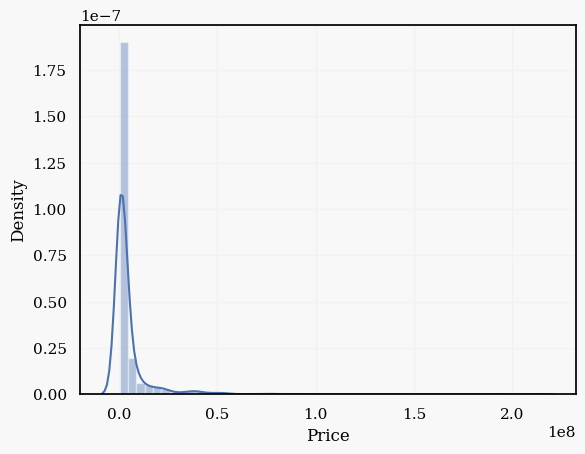

In [658]:
sns.distplot(df["Price"])

#### Find the detail of car having max price

In [659]:
df[df["Price"]==df["Price"].max()]

,Cylinders,Doors,Seating_Capacity,Number_of_Airbags,Make,Model,Variant,Price,Displacement,Drivetrain,Emission_Norm,Keyless_Entry,Power,Torque,Odometer,Speedometer,Tachometer,Tripmeter,Fuel_Type,ARAI_Certified_Mileage,Front_Suspension,Rear_Suspension,Ground_Clearance,Boot_Space,Audiosystem,Third_Row_AC_Vents,Ventilation_System,Auto-Dimming_Rear-View_Mirror,Hill_Assist,Gear_Indicator,ABS_(Anti-lock_Braking_System),EBD_(Electronic_Brake-force_Distribution),Gear_Shift_Reminder,Adjustable_Steering_Column,Parking_Assistance,Key_Off_Reminder,USB_Compatibility,EBA_(Electronic_Brake_Assist),Seat_Height_Adjustment,Navigation_System,Second_Row_AC_Vents,Rear_Center_Armrest,ESP_(Electronic_Stability_Program),Cooled_Glove_Box,Turbocharger,Rain_Sensing_Wipers,Automatic_Headlamps,ASR_/_Traction_Control,Cruise_Control
356,16.0,2.0,2.0,6.0,Bugatti,Chiron,Sport,212155397.0,7993.0,RWD (Rear Wheel Drive),BS 6,"Remote, Smart Key",1600.0,1479.0,Digital,Digital,Digital,Yes,Petrol,5.95,Runflat,Runflat,179.608916,387.585686,CD Player with USB & Aux-in,Not Applicable,Fully automatic climate control,Yes,Yes,Yes,Yes,Yes,Yes,"Rake, Reach",Front & rear sensors with 360 degree view,Yes,Yes,Yes,Electric Adjustment with Memory,Yes,not_defined,Cup Holders,Yes,Yes,Yes,Yes,Yes,Yes,Yes


#### Find the detail of car having min price

In [660]:
df[df["Price"]==df["Price"].min()]

,Cylinders,Doors,Seating_Capacity,Number_of_Airbags,Make,Model,Variant,Price,Displacement,Drivetrain,Emission_Norm,Keyless_Entry,Power,Torque,Odometer,Speedometer,Tachometer,Tripmeter,Fuel_Type,ARAI_Certified_Mileage,Front_Suspension,Rear_Suspension,Ground_Clearance,Boot_Space,Audiosystem,Third_Row_AC_Vents,Ventilation_System,Auto-Dimming_Rear-View_Mirror,Hill_Assist,Gear_Indicator,ABS_(Anti-lock_Braking_System),EBD_(Electronic_Brake-force_Distribution),Gear_Shift_Reminder,Adjustable_Steering_Column,Parking_Assistance,Key_Off_Reminder,USB_Compatibility,EBA_(Electronic_Brake_Assist),Seat_Height_Adjustment,Navigation_System,Second_Row_AC_Vents,Rear_Center_Armrest,ESP_(Electronic_Stability_Program),Cooled_Glove_Box,Turbocharger,Rain_Sensing_Wipers,Automatic_Headlamps,ASR_/_Traction_Control,Cruise_Control
1,2.0,5.0,4.0,2.0,Tata,Nano Genx,Xe,236447.0,624.0,RWD (Rear Wheel Drive),BS IV,not_defined,38.0,51.0,Digital,Analog,Not on offer,Yes,Petrol,23.6,"Independent, Lower Wishbone, McPherson Strut w...","Independent, Semi Trailing arm with coil sprin...",180.0,110.0,Not on offer,Not Applicable,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,Manual Adjustment,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined


In [661]:
len(df[df["Price"]>=df["Price"].mean()])

244

#### Saving the data of above average price in df_a 

In [662]:
df_a=df[df["Price"]>=df["Price"].mean()][["Make","Model","Variant","Price"]]
df_a

,Make,Model,Variant,Price
278,Jaguar,Xe,Se Diesel,4633000.0
279,Jaguar,Xe,Se Petrol,4633000.0
280,Jaguar,Xf,2.0 Prestige,5436329.0
281,Jaguar,Xf,2.0 Portfolio,6073446.0
282,Jaguar,Xf,2.0 Portfolio Diesel,6138811.0
283,Jaguar,Xf,2.0 Prestige Diesel,5506622.0
284,Jaguar,Xf,2.0 Pure Diesel,4977080.0
285,Audi,A3 Cabriolet,40 Tfsi,5038000.0
286,Audi,A6,Premium Plus 45 Tfsi,5442200.0
287,Audi,A6,Technology 45 Tfsi,5942200.0


#### No of companies having price greater than average price

In [663]:
df_a["Make"].nunique()

20

#### Name of companies having price greater than average price

In [664]:
df_a["Make"].value_counts().sort_values(ascending=False)

Mercedes-Benz    42
Land Rover       37
Bmw              31
Audi             21
Jaguar           20
Porsche          14
Lamborghini      13
Lexus            10
Volvo             9
Rolls-Royce       9
Maserati          9
Ferrari           8
Bentley           6
Jeep              5
Aston Martin      3
Toyota            2
Bugatti           2
Ford              1
Nissan            1
Mitsubishi        1
Name: Make, dtype: int64

- Mercedes-Benz have the highest above average price then Land Rover and Bmw.

#### Find out the average price of car whose price is greater than average price of the cars in the data

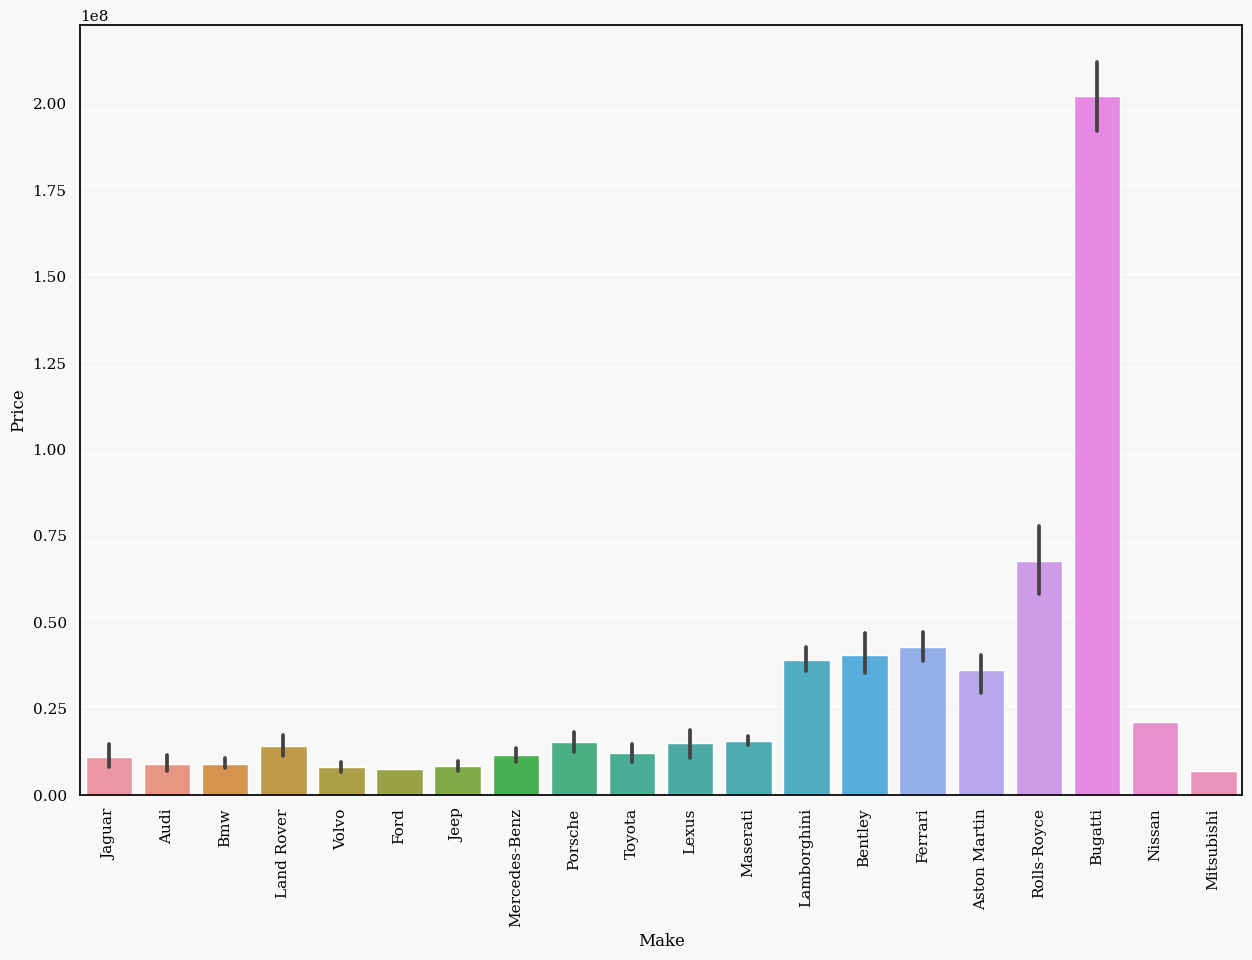

In [665]:
plt.figure(figsize=(15,10))
sns.barplot(x="Make",y="Price",data=df_a)
plt.xticks(rotation=90);

- 1. Bugati
- 2. Rolls-Royace
- 3. Ferrari

#### Average price of no of cars whose price is less than avg car price

In [666]:
len(df[df["Price"]<=df["Price"].mean()])

1032

<AxesSubplot:>

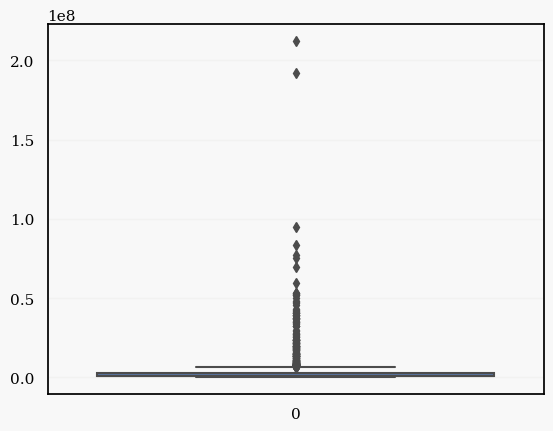

In [667]:
sns.boxplot(df["Price"])

- Variation in Price bcz of outliers.

In [668]:
df[df["Price"]>=150000000]

,Cylinders,Doors,Seating_Capacity,Number_of_Airbags,Make,Model,Variant,Price,Displacement,Drivetrain,Emission_Norm,Keyless_Entry,Power,Torque,Odometer,Speedometer,Tachometer,Tripmeter,Fuel_Type,ARAI_Certified_Mileage,Front_Suspension,Rear_Suspension,Ground_Clearance,Boot_Space,Audiosystem,Third_Row_AC_Vents,Ventilation_System,Auto-Dimming_Rear-View_Mirror,Hill_Assist,Gear_Indicator,ABS_(Anti-lock_Braking_System),EBD_(Electronic_Brake-force_Distribution),Gear_Shift_Reminder,Adjustable_Steering_Column,Parking_Assistance,Key_Off_Reminder,USB_Compatibility,EBA_(Electronic_Brake_Assist),Seat_Height_Adjustment,Navigation_System,Second_Row_AC_Vents,Rear_Center_Armrest,ESP_(Electronic_Stability_Program),Cooled_Glove_Box,Turbocharger,Rain_Sensing_Wipers,Automatic_Headlamps,ASR_/_Traction_Control,Cruise_Control
355,16.0,2.0,2.0,6.0,Bugatti,Chiron,W16,192142937.0,7993.0,RWD (Rear Wheel Drive),BS 6,"Remote, Smart Key",1479.0,1600.0,Digital,Digital,Digital,Yes,Petrol,5.95,MacPherson Strut,Torsion Beam,179.608916,387.585686,CD Player with USB & Aux-in,Not Applicable,Fully automatic climate control,Yes,Yes,Yes,Yes,Yes,Yes,"Rake, Reach",Front & rear sensors with 360 degree view,Yes,Yes,Yes,Electric Adjustment with Memory,Yes,not_defined,Cup Holders,Yes,Yes,Yes,Yes,Yes,Yes,Yes
356,16.0,2.0,2.0,6.0,Bugatti,Chiron,Sport,212155397.0,7993.0,RWD (Rear Wheel Drive),BS 6,"Remote, Smart Key",1600.0,1479.0,Digital,Digital,Digital,Yes,Petrol,5.95,Runflat,Runflat,179.608916,387.585686,CD Player with USB & Aux-in,Not Applicable,Fully automatic climate control,Yes,Yes,Yes,Yes,Yes,Yes,"Rake, Reach",Front & rear sensors with 360 degree view,Yes,Yes,Yes,Electric Adjustment with Memory,Yes,not_defined,Cup Holders,Yes,Yes,Yes,Yes,Yes,Yes,Yes


- Extreme outliers, we will do analysis without these two cars.

#### Saving the data without extreme outliers in x

In [669]:
x=df[df["Price"]<=150000000]
x

,Cylinders,Doors,Seating_Capacity,Number_of_Airbags,Make,Model,Variant,Price,Displacement,Drivetrain,Emission_Norm,Keyless_Entry,Power,Torque,Odometer,Speedometer,Tachometer,Tripmeter,Fuel_Type,ARAI_Certified_Mileage,Front_Suspension,Rear_Suspension,Ground_Clearance,Boot_Space,Audiosystem,Third_Row_AC_Vents,Ventilation_System,Auto-Dimming_Rear-View_Mirror,Hill_Assist,Gear_Indicator,ABS_(Anti-lock_Braking_System),EBD_(Electronic_Brake-force_Distribution),Gear_Shift_Reminder,Adjustable_Steering_Column,Parking_Assistance,Key_Off_Reminder,USB_Compatibility,EBA_(Electronic_Brake_Assist),Seat_Height_Adjustment,Navigation_System,Second_Row_AC_Vents,Rear_Center_Armrest,ESP_(Electronic_Stability_Program),Cooled_Glove_Box,Turbocharger,Rain_Sensing_Wipers,Automatic_Headlamps,ASR_/_Traction_Control,Cruise_Control
0,2.0,5.0,4.0,2.0,Tata,Nano Genx,Xt,292667.0,624.0,RWD (Rear Wheel Drive),BS IV,Remote,38.0,51.0,Digital,Analog,Not on offer,Yes,Petrol,23.600000,"Independent, Lower Wishbone, McPherson Strut w...","Independent, Semi Trailing arm with coil sprin...",180.0,110.0,CD Player with USB & Aux-in,Not Applicable,Manual Air conditioning with cooling and heating,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,Manual Adjustment,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined
1,2.0,5.0,4.0,2.0,Tata,Nano Genx,Xe,236447.0,624.0,RWD (Rear Wheel Drive),BS IV,not_defined,38.0,51.0,Digital,Analog,Not on offer,Yes,Petrol,23.600000,"Independent, Lower Wishbone, McPherson Strut w...","Independent, Semi Trailing arm with coil sprin...",180.0,110.0,Not on offer,Not Applicable,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,Manual Adjustment,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined
2,2.0,4.0,4.0,2.0,Tata,Nano Genx,Emax Xm,296661.0,624.0,RWD (Rear Wheel Drive),BS IV,not_defined,38.0,51.0,Digital,Analog,Not on offer,Yes,CNG,18.667599,"Independent, Lower Wishbone, McPherson Strut w...","Independent, Semi Trailing arm with coil sprin...",180.0,110.0,Not on offer,Not Applicable,Air Conditioning with cooling only,Yes,Yes,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,Manual Adjustment,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined
3,2.0,5.0,4.0,2.0,Tata,Nano Genx,Xta,334768.0,624.0,RWD (Rear Wheel Drive),BS IV,Remote,38.0,51.0,Digital,Analog,Not on offer,Yes,Petrol,21.900000,"Independent, Lower Wishbone, McPherson Strut w...","Independent, Semi Trailing arm with coil sprin...",180.0,94.0,CD Player with USB & Aux-in,Not Applicable,Manual Air conditioning with cooling and heating,not_defined,not_defined,Yes,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,Manual Adjustment,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined
4,2.0,5.0,4.0,2.0,Tata,Nano Genx,Xm,272223.0,624.0,RWD (Rear Wheel Drive),BS IV,not_defined,38.0,51.0,Digital,Analog,Not on offer,Yes,Petrol,23.600000,"Independent, Lower Wishbone, McPherson Strut w...","Independent, Semi Trailing arm with coil sprin...",180.0,110.0,Not on offer,Not Applicable,Air Conditioning with cooling only,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,Manual Adjustment,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [670]:
x["Price"].mean()

4286408.171114599

#### Correlation of numeric columns w.r.t. price

In [671]:
df.corr()["Price"]

Cylinders                 0.817001
Doors                    -0.460311
Seating_Capacity         -0.307150
Number_of_Airbags         0.335710
Price                     1.000000
Displacement              0.793245
Power                     0.855190
Torque                    0.702178
ARAI_Certified_Mileage   -0.207905
Ground_Clearance         -0.012123
Boot_Space                0.049548
Name: Price, dtype: float64

- Cylinders, Displacement, Power, and Torque are positively correlated.
- Seating_Capacity is negatively correlated.

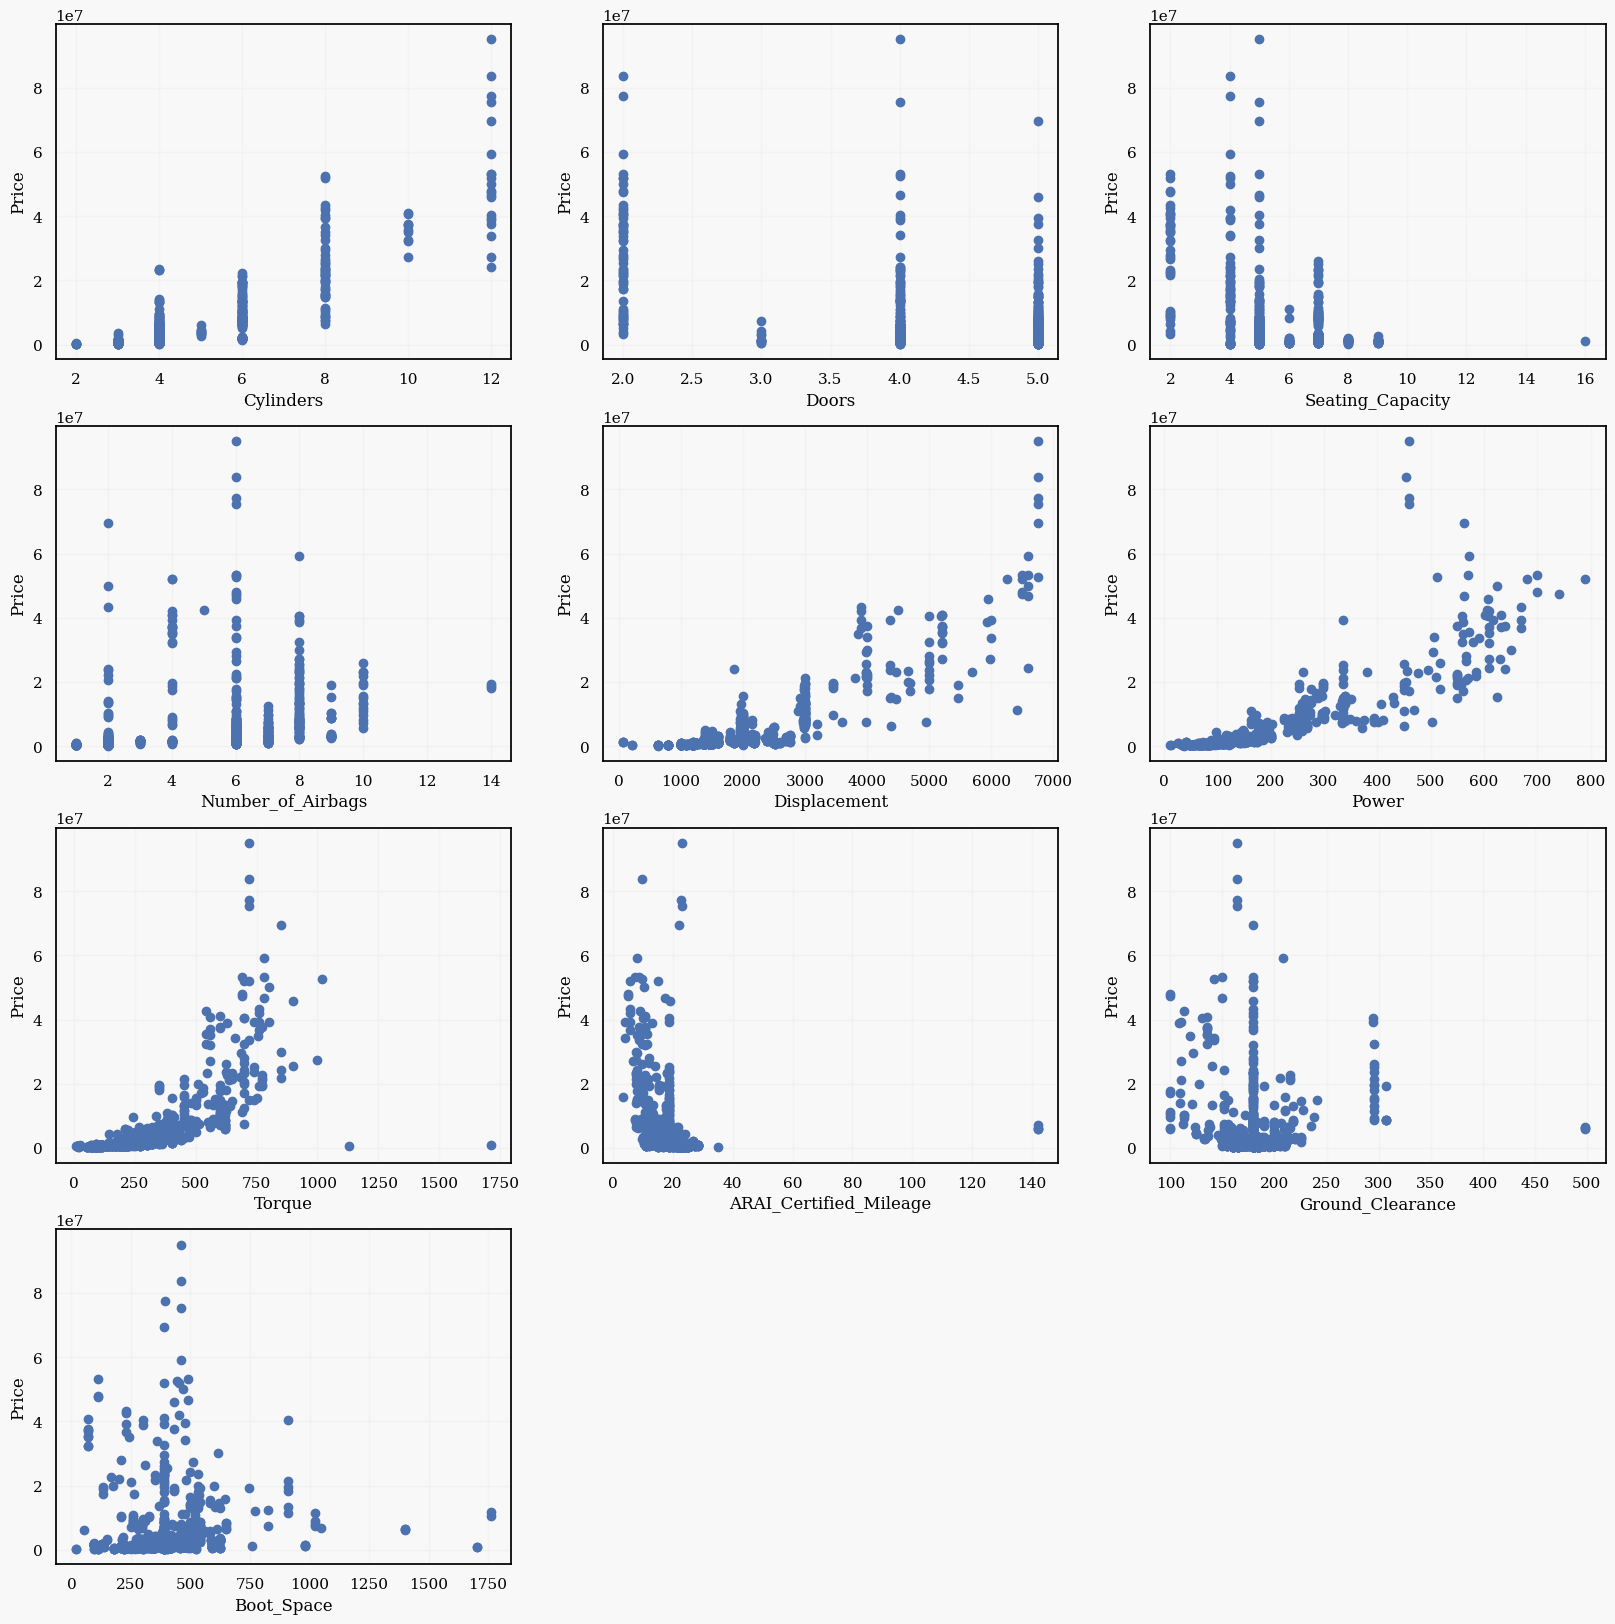

In [672]:
numeric=["int32","float64"]
n=1
plt.figure(figsize=(20,20))
for i in x.select_dtypes(include=numeric):
    if i!="Price":
        plt.subplot(4,3,n)
        plt.scatter(x[i],x["Price"])
        #plt.title(i)
        plt.xlabel(i)
        plt.ylabel("Price")
        n=n+1

#### Insights:
- Price, Cylinders, Doors, and Seating_Capacity(mostly 4-5 seats cars are costlier) don't have linear relationship
- Displacement, Power, and Torque have sort of linear relationship

#### How many cars of each company?

In [673]:
df["Make"].value_counts()

Maruti Suzuki    163
Hyundai          130
Mahindra         119
Tata             100
Toyota            82
Honda             64
Mercedes-Benz     57
Skoda             43
Ford              43
Land Rover        37
Bmw               37
Renault           36
Volkswagen        34
Audi              31
Nissan            29
Jeep              28
Datsun            24
Fiat              23
Jaguar            22
Kia               21
Volvo             18
Porsche           14
Mg                13
Lamborghini       13
Icml              11
Mini              10
Lexus             10
Maserati           9
Rolls-Royce        9
Ferrari            8
Mitsubishi         7
Bentley            6
Force              6
Premier            6
Isuzu              5
Aston Martin       3
Bugatti            2
Bajaj              2
Dc                 1
Name: Make, dtype: int64

- Most Demanding companies are Maruti Suzuki, Hyundai, Mahindra, Tata, Toyota.
- Least in Demand is Dc

#### Min, Max, and avg Price of the cars based on their company

In [674]:
df.groupby(["Make"])["Price"].agg(["min","max","mean"]).sort_values(by="mean",ascending=False).head()

,min,max,mean
Make,,,
Bugatti,192142937.0,212155397.0,2.021492e+08
Rolls-Royce,46709733.0,95000000.0,6.779633e+07
Ferrari,35000000.0,52000000.0,4.287250e+07
Bentley,33791059.0,52571294.0,4.056585e+07
Lamborghini,30000000.0,53210327.0,3.905392e+07


- Top 3 expensive car brands are Bugatti, Rolls-Royce and Ferrari.
- Least expensive car is Bajaj.

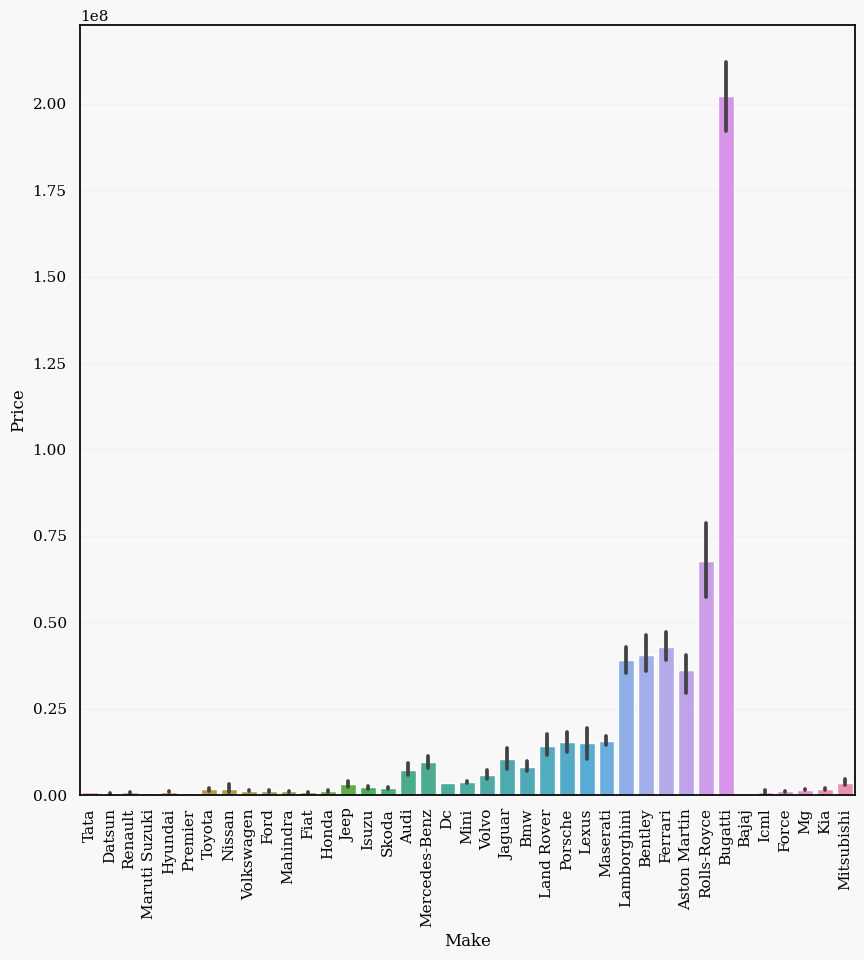

In [675]:
plt.figure(figsize=(10,10))
sns.barplot(x="Make",y="Price",data=df);
plt.xticks(rotation=90);

#### Details of Top 3 expensive companies and their cars

In [676]:
df[((df["Make"]=="Bugatti")|(df["Make"]=="Ferrari")|(df["Make"]=="Rolls-Royce"))].head()

,Cylinders,Doors,Seating_Capacity,Number_of_Airbags,Make,Model,Variant,Price,Displacement,Drivetrain,Emission_Norm,Keyless_Entry,Power,Torque,Odometer,Speedometer,Tachometer,Tripmeter,Fuel_Type,ARAI_Certified_Mileage,Front_Suspension,Rear_Suspension,Ground_Clearance,Boot_Space,Audiosystem,Third_Row_AC_Vents,Ventilation_System,Auto-Dimming_Rear-View_Mirror,Hill_Assist,Gear_Indicator,ABS_(Anti-lock_Braking_System),EBD_(Electronic_Brake-force_Distribution),Gear_Shift_Reminder,Adjustable_Steering_Column,Parking_Assistance,Key_Off_Reminder,USB_Compatibility,EBA_(Electronic_Brake_Assist),Seat_Height_Adjustment,Navigation_System,Second_Row_AC_Vents,Rear_Center_Armrest,ESP_(Electronic_Stability_Program),Cooled_Glove_Box,Turbocharger,Rain_Sensing_Wipers,Automatic_Headlamps,ASR_/_Traction_Control,Cruise_Control
344,8.0,2.0,2.0,4.0,Ferrari,Portofino,V8 Convertible,35000000.0,3855.0,AWD (All Wheel Drive),BS IV,Smart Key,560.0,755.0,Digital,Analog,Analog,Yes,Petrol,9.00,Double wishbone suspension,Multilink,119.000000,240.0,CD Player with USB & Aux-in,Not Applicable,2 Zone Climate Control,not_defined,Yes,Yes,Yes,Yes,Yes,"Rake, Reach",Front and rear sensors with camera,Yes,Yes,Yes,Electric Adjustment with Memory,Yes,Yes,not_defined,Yes,Yes,not_defined,Yes,Yes,Yes,Yes
348,8.0,2.0,2.0,5.0,Ferrari,458 Speciale,Coupe,42531500.0,4497.0,AWD (All Wheel Drive),BS IV,Smart Key,605.0,540.0,Digital,Analog,Analog,Yes,Petrol,9.00,Twin wishbones,multi-link set-up,113.000000,230.0,DVD Player with USB & Aux-in,Not Applicable,Fully automatic climate control,not_defined,Yes,Yes,Yes,Yes,Yes,"Rake, Reach",Front & rear sensors with 360 degree view,Yes,Yes,Yes,Electric Adjustment,Yes,not_defined,not_defined,Yes,Yes,not_defined,Yes,Yes,Yes,Yes
349,12.0,4.0,5.0,6.0,Rolls-Royce,Rolls-Royce Ghost Series Ii,6.6,46709733.0,6593.0,RWD (Rear Wheel Drive),BS IV,Smart Key,563.0,780.0,Digital,Analog,Analog,Yes,Petrol,17.30,Independent Double Wishbone with Air Springs,Independent Multi-Link with Air Springs,150.000000,490.0,DVD Player with USB & Aux-in,not_defined,Fully automatic climate control,not_defined,Yes,Yes,Yes,Yes,Yes,"Rake, Reach",Front & rear sensors with 360 degree view,Yes,Yes,Yes,Electric Adjustment with Memory,Yes,Yes,Cup Holders,Yes,Yes,not_defined,Yes,Yes,Yes,Yes
350,12.0,4.0,5.0,6.0,Rolls-Royce,Rolls-Royce Ghost Series Ii,Ewb,53247201.0,6592.0,RWD (Rear Wheel Drive),BS IV,Smart Key,570.0,780.0,Digital,Analog,Analog,Yes,Petrol,7.29,Independent Double Wishbone with Air Springs,Independent Multi-Link with Air Springs,150.000000,490.0,DVD Player with USB & Aux-in,not_defined,Fully automatic climate control,not_defined,Yes,Yes,Yes,Yes,Yes,"Rake, Reach",Front & rear sensors with 360 degree view,Yes,Yes,Yes,Electric Adjustment with Memory,Yes,Yes,Cup Holders,Yes,Yes,not_defined,Yes,Yes,Yes,Yes
351,12.0,2.0,4.0,2.0,Rolls-Royce,Rolls-Royce Wraith,Coupe,50025840.0,6592.0,AWD (All Wheel Drive),BS IV,Smart Key,625.0,800.0,Digital,not_defined,Yes,Yes,Petrol,10.20,Double wishbone,Multi-Link,179.608916,470.0,CD Player with USB & Aux-in,not_defined,"Fully automatic climate control, 2 Zone Climat...",not_defined,not_defined,Yes,Yes,Yes,not_defined,"Rake, Reach",Front and rear sensors with camera,Yes,Yes,not_defined,Electric Adjustment with Memory,Yes,not_defined,Yes,not_defined,not_defined,not_defined,not_defined,Yes,Yes,Yes


#### Now we will find out why Bugatti, Rolls-Royce, and Ferrari are expensive cars based on the four premium features Cylinder, Displacement, Power and Torque.

In [677]:
grp=df.groupby(["Make"])["Cylinders","Displacement","Power","Torque"]

In [678]:
grp.get_group("Bugatti")

,Cylinders,Displacement,Power,Torque
355,16.0,7993.0,1479.0,1600.0
356,16.0,7993.0,1600.0,1479.0


- Bugatti has 16 cylinders and highest Displacement, Power and Torque, features for high cost.

In [679]:
grp.get_group("Rolls-Royce")

,Cylinders,Displacement,Power,Torque
349,12.0,6593.0,563.0,780.0
350,12.0,6592.0,570.0,780.0
351,12.0,6592.0,625.0,800.0
353,12.0,6750.0,563.0,850.0
354,12.0,6749.0,460.0,720.0
879,12.0,6598.0,571.0,780.0
880,12.0,6749.0,453.0,720.0
1219,12.0,6749.0,460.0,720.0
1220,12.0,6749.0,460.0,720.0


- Rolls-Royce has 12 cylinders and second highest Displacement, Power and Torque.

In [680]:
grp.get_group("Ferrari")

,Cylinders,Displacement,Power,Torque
344,8.0,3855.0,560.0,755.0
348,8.0,4497.0,605.0,540.0
872,8.0,3902.0,670.0,760.0
873,8.0,3902.0,670.0,760.0
874,8.0,3900.0,610.0,760.0
875,8.0,6262.0,681.0,697.0
1058,12.0,6496.0,789.0,718.0
1172,8.0,3902.0,669.0,760.0


- Ferrari has 8 and 12 cylinders and third highest Displacement, Power and Torque.

### Buyers can choose the car based on the following important factor:
- 1. safety---- no of airbags
- 2. power
- 3. torque 
- 4. mileage
- 5. seating_capacity and 
- 6. fuel_type.

#### Number_of_Airbags

In [681]:
df.groupby(["Make"])["Number_of_Airbags"].agg(["min","max","mean"]).sort_values(by="mean",ascending=False).head()

,min,max,mean
Make,,,
Lexus,8.0,14.0,10.600000
Audi,4.0,10.0,7.580645
Land Rover,2.0,10.0,7.486486
Aston Martin,6.0,8.0,7.333333
Mercedes-Benz,2.0,10.0,7.192982


- Lexus provides highest 14 airbags, after that Audi, Land Rover, and Mercedes-Benz provides 10 airbags.

#### Power

In [682]:
df.groupby(["Make"])["Power"].agg(["min","max","mean"]).sort_values(by="mean",ascending=False).head()

,min,max,mean
Make,,,
Bugatti,1479.0,1600.0,1539.500000
Ferrari,560.0,789.0,656.750000
Lamborghini,571.0,740.0,636.461538
Bentley,507.0,616.0,563.833333
Aston Martin,505.0,608.0,557.666667


- Bugatti has the highest power i.e. 1600 after that Ferrari provides 789.

#### Torque

In [683]:
df.groupby(["Make"])["Torque"].agg(["min","max","mean"]).sort_values(by="mean",ascending=False).head()

,min,max,mean
Make,,,
Bugatti,1479.0,1600.0,1539.500000
Bentley,660.0,1020.0,811.666667
Rolls-Royce,720.0,850.0,763.333333
Ferrari,540.0,760.0,718.750000
Aston Martin,630.0,700.0,671.666667


- Bugatti has highest torque 1600, after that Bentley i.e. 1020.

#### Seating_Capacity

In [684]:
df.groupby(["Make"])["Seating_Capacity"].agg(["min","max","mean"]).sort_values(by="mean",ascending=False).head()

,min,max,mean
Make,,,
Icml,7.0,9.0,8.454545
Mitsubishi,7.0,7.0,7.000000
Mahindra,4.0,9.0,6.512605
Land Rover,4.0,7.0,6.135135
Isuzu,5.0,7.0,5.800000


- lcml and Mahindra provides highest Seating_Capacity i.e. 9.

#### ARAI_Certified_Mileage	

In [685]:
df.groupby(["Make"])["ARAI_Certified_Mileage"].agg(["min","max","mean"]).sort_values(by="mean",ascending=False).head()

,min,max,mean
Make,,,
Bajaj,18.667599,35.00,26.833799
Mercedes-Benz,7.800000,142.00,22.974842
Maruti Suzuki,11.900000,28.40,22.318901
Honda,14.400000,27.40,21.362500
Datsun,20.100000,25.17,21.353333


- Bajaj has highest average mileage i.e. 26.8

#### Fuel_type

In [686]:
df["Fuel_Type"].value_counts()

Petrol          643
Diesel          582
CNG              16
Hybrid           15
Electric         14
CNG + Petrol      6
Name: Fuel_Type, dtype: int64

- Customers preferred Petrol fuel_type.

In [687]:
g_f=df.groupby(["Make"])["Fuel_Type"]

In [688]:
#for i in df["Make"]:
    #print(i,"\n",g_f.get_group(i).values)